# Script to use apply sensor specific calibrations to raw data, and compare to GC results

# Runs the file cntaining general functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [45]:
methaneFunctions<-paste(getwd(),"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)) {
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# Load packages

In [46]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis", "ggpubr")
packageHandler(packages)

# Run

In [3]:
directory<-"~/Desktop/data/Methane Calibration/field_test/20230317_deployment"
dir.exists(directory)

[1] TRUE

In [4]:
rrivDir<-paste0(directory,"/RRIV")
gcDir<-paste0(directory,"/GC")

dir.exists(rrivDir)
dir.exists(gcDir)

[1] TRUE

[1] TRUE

In [5]:
outputDir<-paste0(directory,"_output")
newDir(outputDir)

Output directory, ~/Desktop/data/Methane Calibration/field_test/20230317_deployment_output, already exists


# Read in RRIV data and process columns

In [6]:
rrivData<-concat_dirs(rrivDir,read_rriv_CSV)
rrivData<-process_rriv_columns(rrivData)
str(rrivData)

[1] "Dataframe generated, manually process column types if necessary"
'data.frame':	143072 obs. of  20 variables:
 $ type            : Factor w/ 2 levels "raw","summary": 1 1 1 1 1 1 1 1 1 1 ...
 $ site            : Factor w/ 4 levels "ACRE","LPS","PWA1",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ logger          : Factor w/ 4 levels "21010","21011",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ deployment      : Factor w/ 4 levels "calCH001_field-57FF70068387575129270167-1679068374",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ deployed_at     : int  1679068113 1679068113 1679068113 1679068113 1679068113 1679068113 1679068113 1679068113 1679068113 1679068113 ...
 $ uuid            : Factor w/ 4 levels "50FF6C068678545210222467",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ time.s          : num  1.68e+09 1.68e+09 1.68e+09 1.68e+09 1.68e+09 ...
 $ time.h          : POSIXct, format: "2023-03-17 16:00:14" "2023-03-17 16:00:17" ...
 $ battery.V       : num  1196 1077 1060 1059 1059 ...
 $ measurementCycle: num  1 1 1 1 1 1 1 1 1 1 ...
 $ burstCyc

# Subset raw and summary lines from data

In [7]:
raw_rd<-rrivData[rrivData$type == "raw",]
head(raw_rd)

summary_rd<-rrivData[rrivData$type == "summary",]
head(summary_rd)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,burstCycle,dht_C,dht_RH,atlas_CO2_ppm,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
9,raw,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068815,2023-03-17 16:00:14,1196,1,1,20.8,16.2,1528,1902,0,660,0,NA,NA
16,raw,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068817,2023-03-17 16:00:17,1077,1,1,20.8,16.2,1528,1902,0,615,0,NA,NA
23,raw,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068820,2023-03-17 16:00:19,1060,1,1,20.7,17.7,1527,1901,0,596,0,NA,NA
30,raw,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068822,2023-03-17 16:00:22,1059,1,1,20.7,17.7,1526,1900,0,589,0,NA,NA
37,raw,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068825,2023-03-17 16:00:24,1059,1,1,20.7,17.7,1525,1901,0,590,0,NA,NA
44,raw,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068827,2023-03-17 16:00:27,1059,1,1,20.7,17.7,1524,1901,0,594,0,NA,NA


,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,burstCycle,dht_C,dht_RH,atlas_CO2_ppm,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
77,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068837,2023-03-17 16:00:37,1071,1,1,20.72,17.40,1524.3,1901.2,0,611.4,0,NA,NA
152,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068897,2023-03-17 16:01:37,1144,1,2,20.72,18.16,1516.5,1911.4,0,840.8,0,NA,NA
227,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068957,2023-03-17 16:02:37,1175,1,3,20.86,19.00,1521.0,1928.7,0,973.5,0,NA,NA
302,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069017,2023-03-17 16:03:37,1182,1,4,21.02,19.46,1525.4,1946.4,0,1006.6,0,NA,NA
377,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069077,2023-03-17 16:04:37,1181,1,5,21.26,19.60,1530.1,1958.7,0,1006.0,0,NA,NA
452,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069138,2023-03-17 16:05:37,1182,1,6,21.56,19.60,1537.7,1968.7,0,1000.6,0,NA,NA


# Create dictionary linking UUIDs to specific Sensors

In [51]:
#manual dictionary to link UUIDs to sensors

UUIDdict<-c(
    '57FF70068387575129270167' = 'CH001',
    '57FF6C068387575136470767' = 'CH002',
    '50FF6F068678545226521667' = 'CH003',
    '50FF6C068678545210222467' = 'CH004',
    '57FF6E068387575145101167' = 'CH005',
    '57FF74068387575109431367' = 'CH006'
)
UUIDdict

57FF70068387575129270167 57FF6C068387575136470767 50FF6F068678545226521667 
                 "CH001"                  "CH002"                  "CH003" 
50FF6C068678545210222467 57FF6E068387575145101167 57FF74068387575109431367 
                 "CH004"                  "CH005"                  "CH006"

# Create Sensor column from dictionary

In [9]:
summary_rd<-createSensorColFromIDs(summary_rd, "uuid", UUIDdict)
head(summary_rd)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,⋯,dht_C,dht_RH,atlas_CO2_ppm,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,Sensor
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>
77,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068837,2023-03-17 16:00:37,1071,1,⋯,20.72,17.40,1524.3,1901.2,0,611.4,0,NA,NA,CH003
152,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068897,2023-03-17 16:01:37,1144,1,⋯,20.72,18.16,1516.5,1911.4,0,840.8,0,NA,NA,CH003
227,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068957,2023-03-17 16:02:37,1175,1,⋯,20.86,19.00,1521.0,1928.7,0,973.5,0,NA,NA,CH003
302,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069017,2023-03-17 16:03:37,1182,1,⋯,21.02,19.46,1525.4,1946.4,0,1006.6,0,NA,NA,CH003
377,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069077,2023-03-17 16:04:37,1181,1,⋯,21.26,19.60,1530.1,1958.7,0,1006.0,0,NA,NA,CH003
452,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069138,2023-03-17 16:05:37,1182,1,⋯,21.56,19.60,1537.7,1968.7,0,1000.6,0,NA,NA,CH003


# Calculate Absolute Humidity

In [10]:
summary_rd<-calcAbsoluteHumidity(summary_rd)
head(summary_rd)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,⋯,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,Sensor,ews_mbar,ews_kPa,aH_gm3
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>
77,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068837,2023-03-17 16:00:37,1071,1,⋯,1901.2,0,611.4,0,NA,NA,CH003,12.34785,1.234785,1.584171
152,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068897,2023-03-17 16:01:37,1144,1,⋯,1911.4,0,840.8,0,NA,NA,CH003,12.34785,1.234785,1.653365
227,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068957,2023-03-17 16:02:37,1175,1,⋯,1928.7,0,973.5,0,NA,NA,CH003,12.54203,1.254203,1.756209
302,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069017,2023-03-17 16:03:37,1182,1,⋯,1946.4,0,1006.6,0,NA,NA,CH003,12.76743,1.276743,1.830058
377,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069077,2023-03-17 16:04:37,1181,1,⋯,1958.7,0,1006.0,0,NA,NA,CH003,13.11262,1.311262,1.891515
452,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069138,2023-03-17 16:05:37,1182,1,⋯,1968.7,0,1000.6,0,NA,NA,CH003,13.55632,1.355632,1.953529


# Calculate V0 from linear models

In [11]:
lmFile<-"~/Desktop/data/Methane Calibration/methane_calibration_v0_output/V0_lm_CH001-CH006.rds"
summary_rd<-calcV0(summary_rd, lmFile)
head(summary_rd)

[1] "CH003"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
    315.3680       -0.3705      138.8468       -3.1268  

[1] "CH004"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
     408.379         3.647        36.874        -0.443  

[1] "CH001"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
      925.61        -66.84       2048.70        -50.48  

[1] "CH002"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
     447.524        20.447       334.416        -8.043  



,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,⋯,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,Sensor,ews_mbar,ews_kPa,aH_gm3,v0
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
77,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068837,2023-03-17 16:00:37,1071,1,⋯,0,611.4,0,NA,NA,CH003,12.34785,1.234785,1.584171,425.0158
152,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068897,2023-03-17 16:01:37,1144,1,⋯,0,840.8,0,NA,NA,CH003,12.34785,1.234785,1.653365,430.1403
227,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068957,2023-03-17 16:02:37,1175,1,⋯,0,973.5,0,NA,NA,CH003,12.54203,1.254203,1.756209,436.9362
302,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069017,2023-03-17 16:03:37,1182,1,⋯,0,1006.6,0,NA,NA,CH003,12.76743,1.276743,1.830058,441.3983
377,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069077,2023-03-17 16:04:37,1181,1,⋯,0,1006.0,0,NA,NA,CH003,13.11262,1.311262,1.891515,444.3838
452,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069138,2023-03-17 16:05:37,1182,1,⋯,0,1000.6,0,NA,NA,CH003,13.55632,1.355632,1.953529,446.9283


# Calculate sensor resistance Rs

In [12]:
summary_rd<-calcSensorResistance(summary_rd)
head(summary_rd)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,⋯,user_note,user_value,Sensor,ews_mbar,ews_kPa,aH_gm3,v0,ch4_V,v0_V,Rs_Ω
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
77,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068837,2023-03-17 16:00:37,1071,1,⋯,NA,NA,CH003,12.34785,1.234785,1.584171,425.0158,0.7463379,0.5188181,0.6598573
152,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068897,2023-03-17 16:01:37,1144,1,⋯,NA,NA,CH003,12.34785,1.234785,1.653365,430.1403,1.0263672,0.5250736,0.4542754
227,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679068957,2023-03-17 16:02:37,1175,1,⋯,NA,NA,CH003,12.54203,1.254203,1.756209,436.9362,1.1883545,0.5333694,0.3830139
302,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069017,2023-03-17 16:03:37,1182,1,⋯,NA,NA,CH003,12.76743,1.276743,1.830058,441.3983,1.2287598,0.5388163,0.3706874
377,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069077,2023-03-17 16:04:37,1181,1,⋯,NA,NA,CH003,13.11262,1.311262,1.891515,444.3838,1.2280273,0.5424607,0.3737951
452,summary,ACRE,kcdev,calCH003_field-50FF6F068678545226521667-1679068113,1679068113,50FF6F068678545226521667,1679069138,2023-03-17 16:05:37,1182,1,⋯,NA,NA,CH003,13.55632,1.355632,1.953529,446.9283,1.2214355,0.5455668,0.3788888


# Calculate CH4_cal from linear models

In [13]:
bastvikenLmFile<-"~/Desktop/data/Methane Calibration/bastvikenEquations_output/bastviken_lm.rds"
summary_rd<-calcCH4_cal(summary_rd, bastvikenLmFile)

[1] "CH003"

Call:
lm(formula = gc.ch4.ppm ~ Rs_Ω * dht_C * aH_gm3, data = temp)

Coefficients:
      (Intercept)               Rs_Ω              dht_C             aH_gm3  
           8300.4          -278508.8            -2077.7            22083.8  
       Rs_Ω:dht_C        Rs_Ω:aH_gm3       dht_C:aH_gm3  Rs_Ω:dht_C:aH_gm3  
          13809.1            36001.6             -425.2            -2120.1  

[1] "CH004"

Call:
lm(formula = gc.ch4.ppm ~ Rs_Ω * dht_C * aH_gm3, data = temp)

Coefficients:
      (Intercept)               Rs_Ω              dht_C             aH_gm3  
          31548.5            21458.7            -1337.2           -17554.6  
       Rs_Ω:dht_C        Rs_Ω:aH_gm3       dht_C:aH_gm3  Rs_Ω:dht_C:aH_gm3  
          -1057.6           -19911.4              790.9              899.0  

[1] "CH001"

Call:
lm(formula = gc.ch4.ppm ~ Rs_Ω * dht_C * aH_gm3, data = temp)

Coefficients:
      (Intercept)               Rs_Ω              dht_C             aH_gm3  
           581769

In [14]:
saveDFcsv(summary_rd,tag = "calibrated")
saveDFrds(summary_rd,tag = "calibrated")

[1] "~/Desktop/data/Methane Calibration/field_test/20230317_deployment_output/summary_rd_calibrated.csv"
[1] "~/Desktop/data/Methane Calibration/field_test/20230317_deployment_output/summary_rd_calibrated.rds"


# Plots

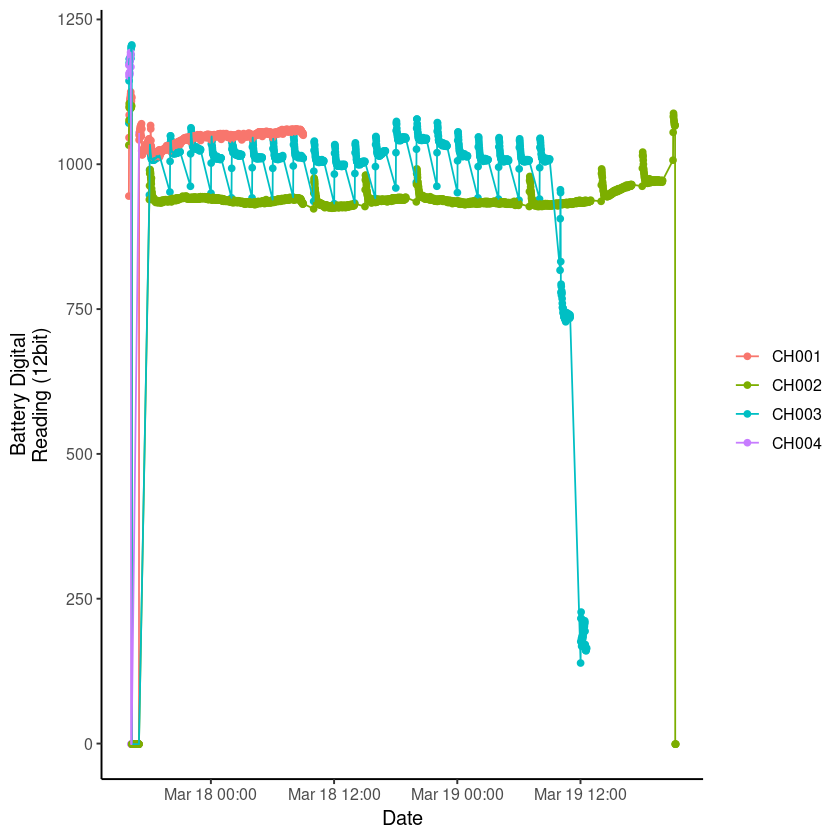

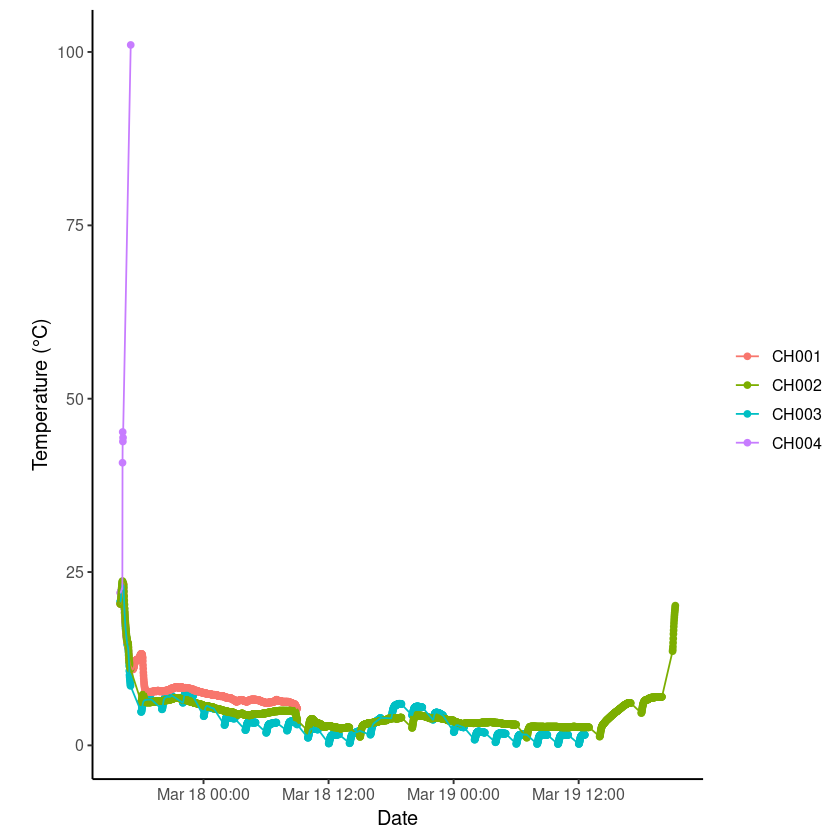

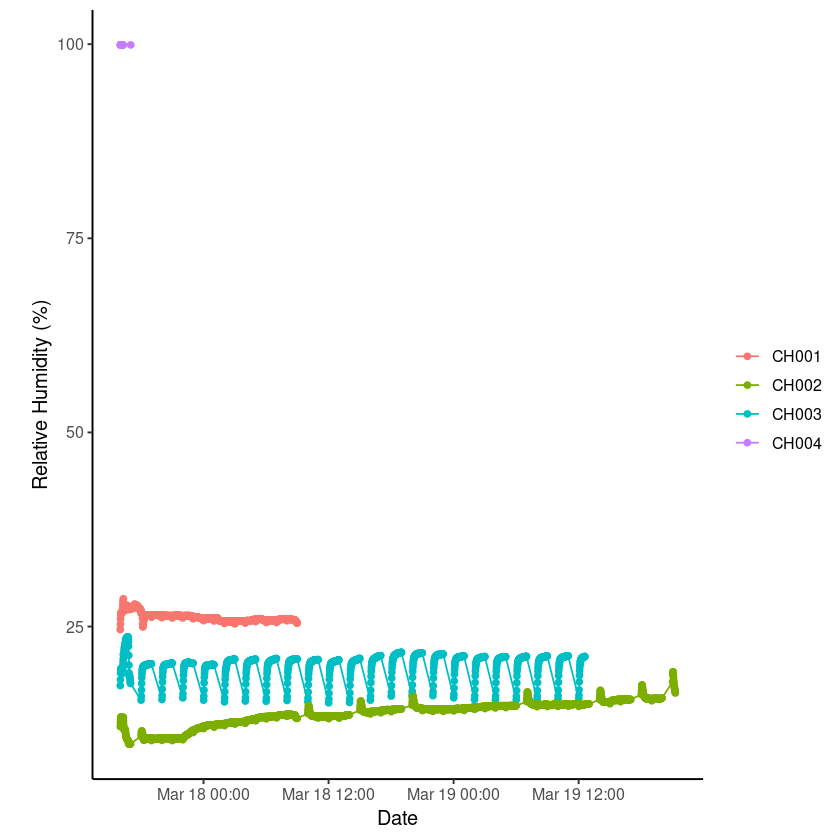

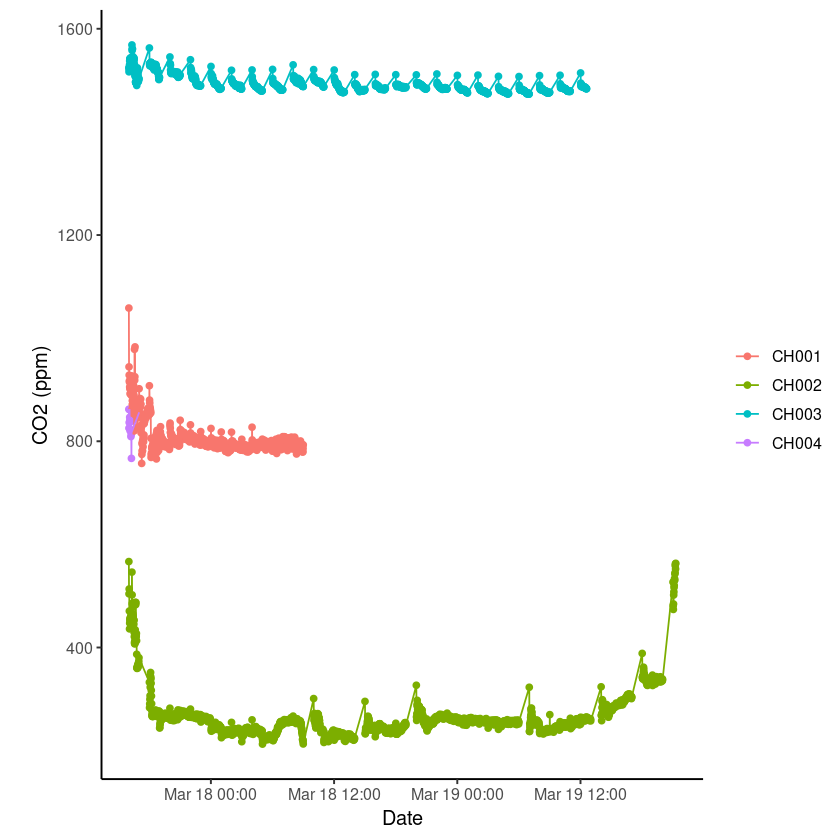

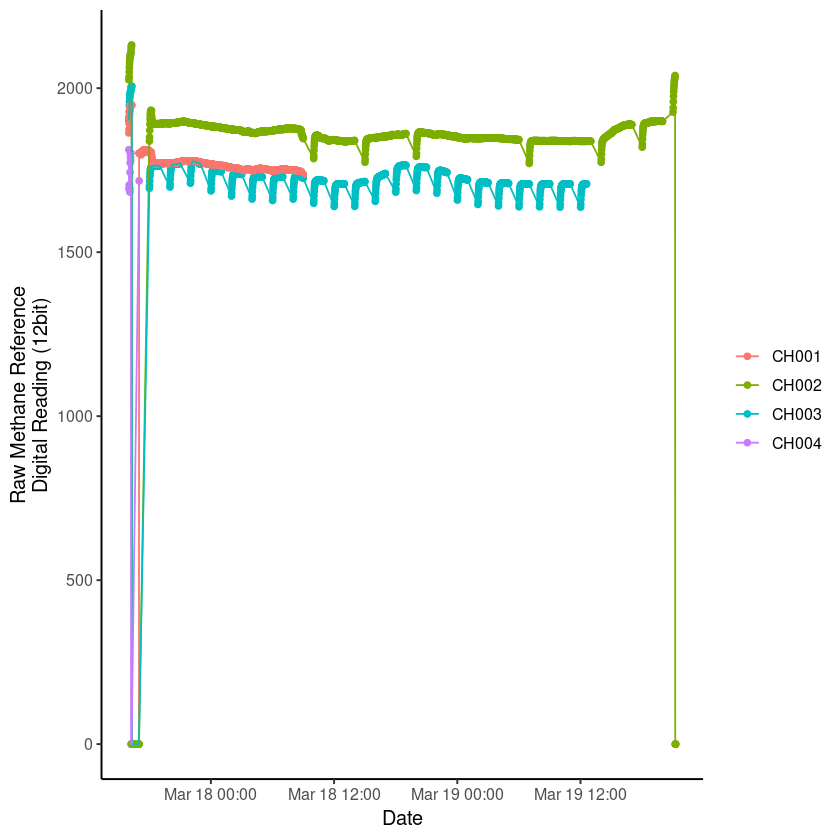

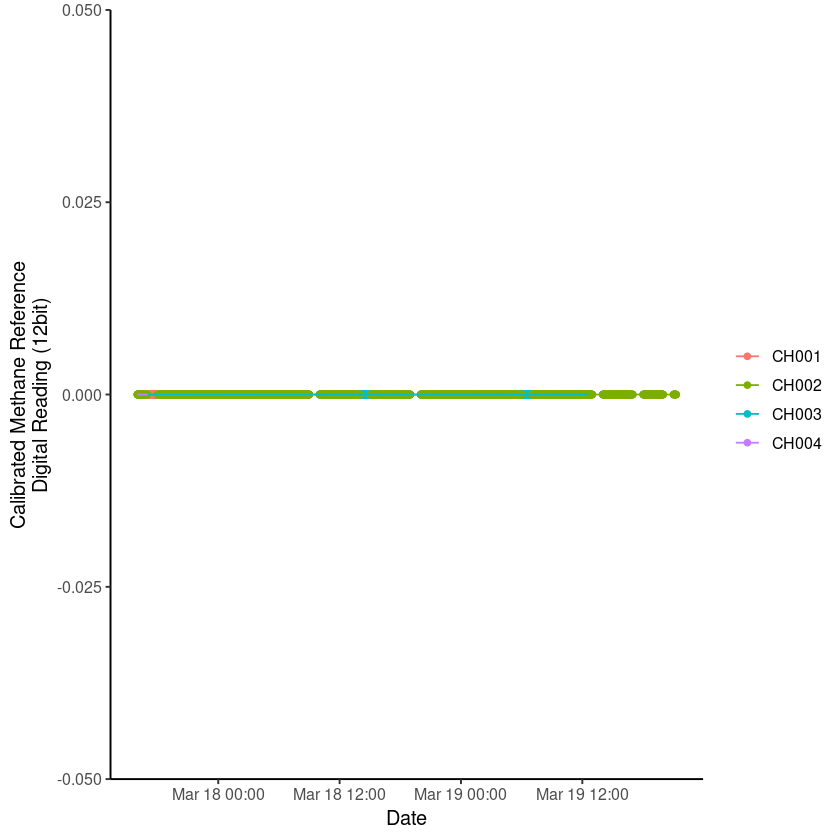

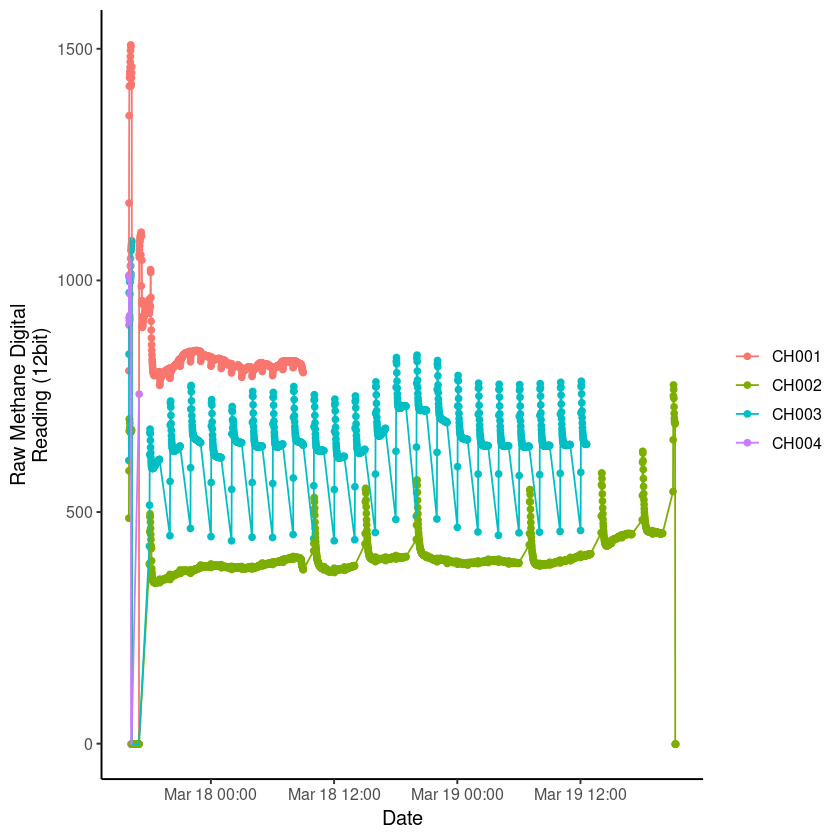

$battery.V

$dht_C

$dht_RH

$atlas_CO2_ppm

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$aH_gm3


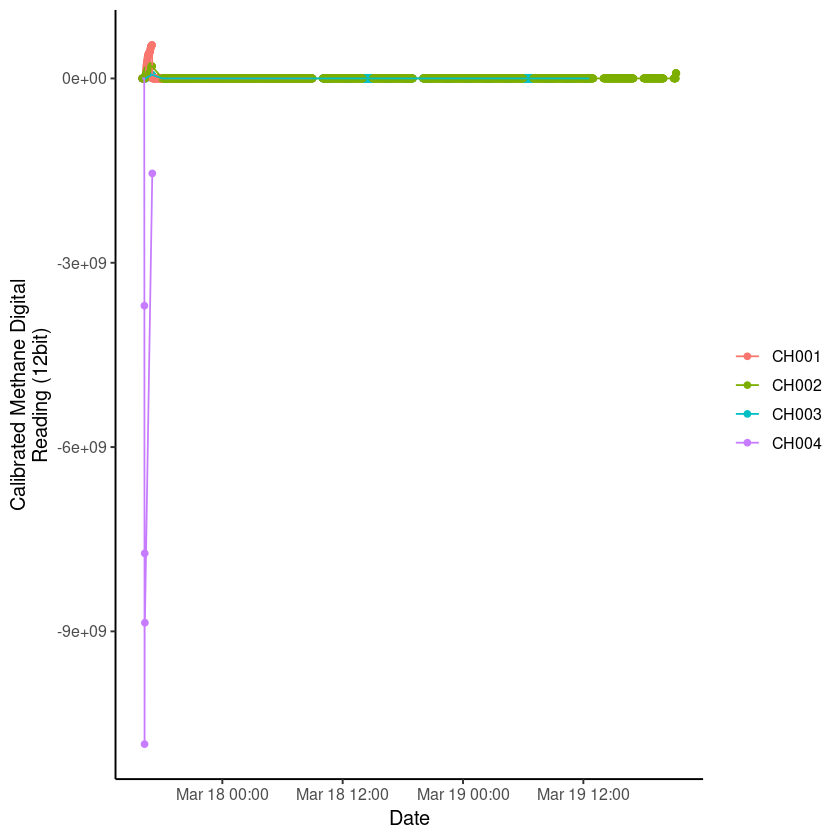

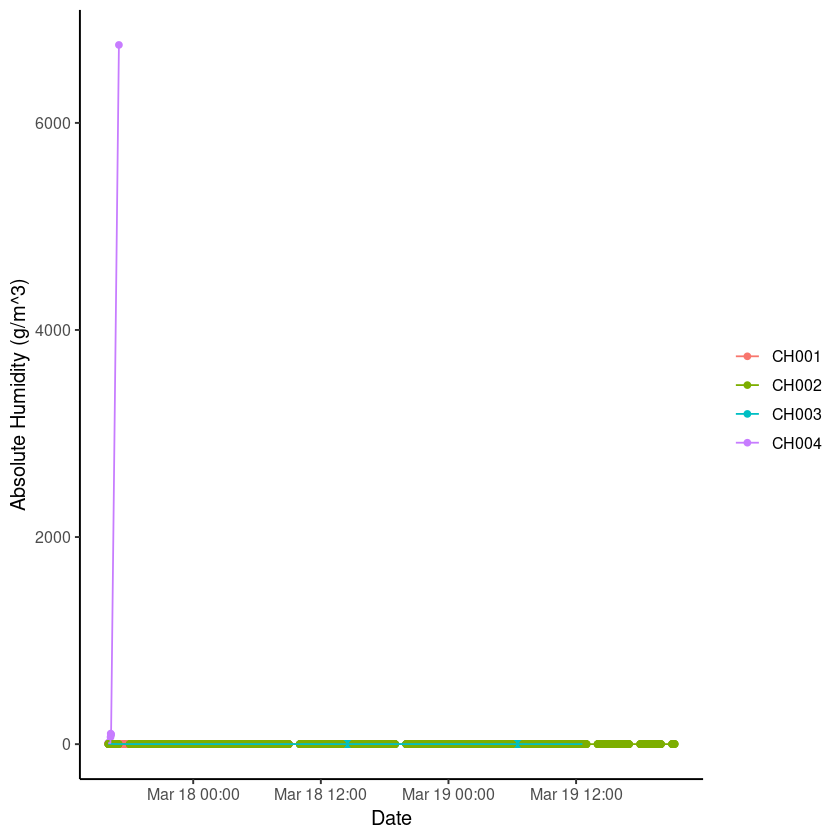

In [50]:
DvTplots<-plot_Data_v_Time(df = summary_rd, color = "Sensor")
DvTplots

# savePlotList(DvTplots, tag="DvT")

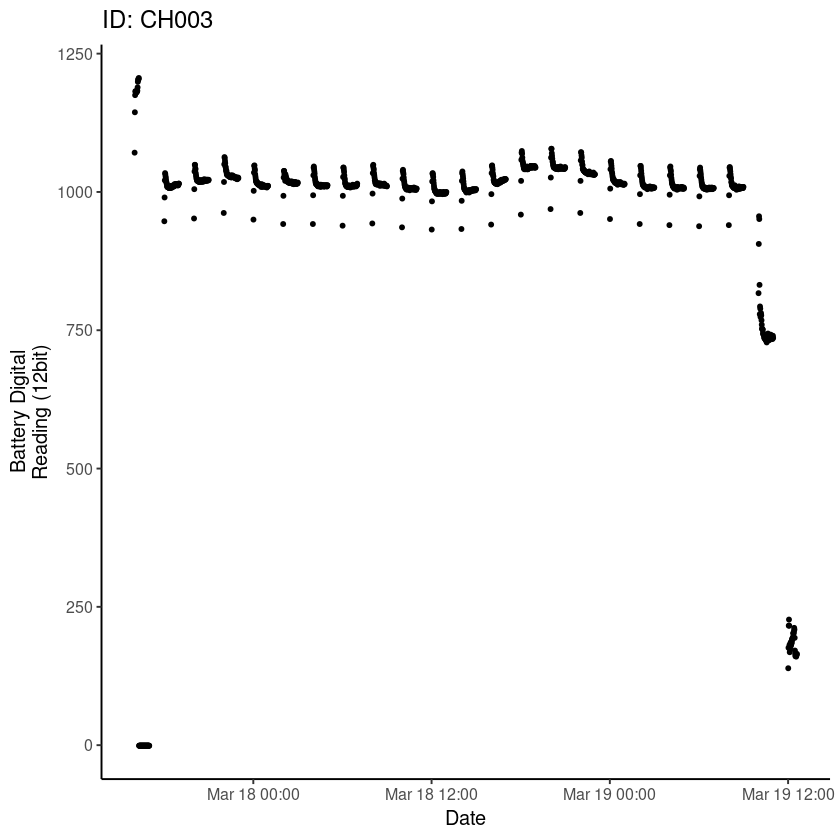

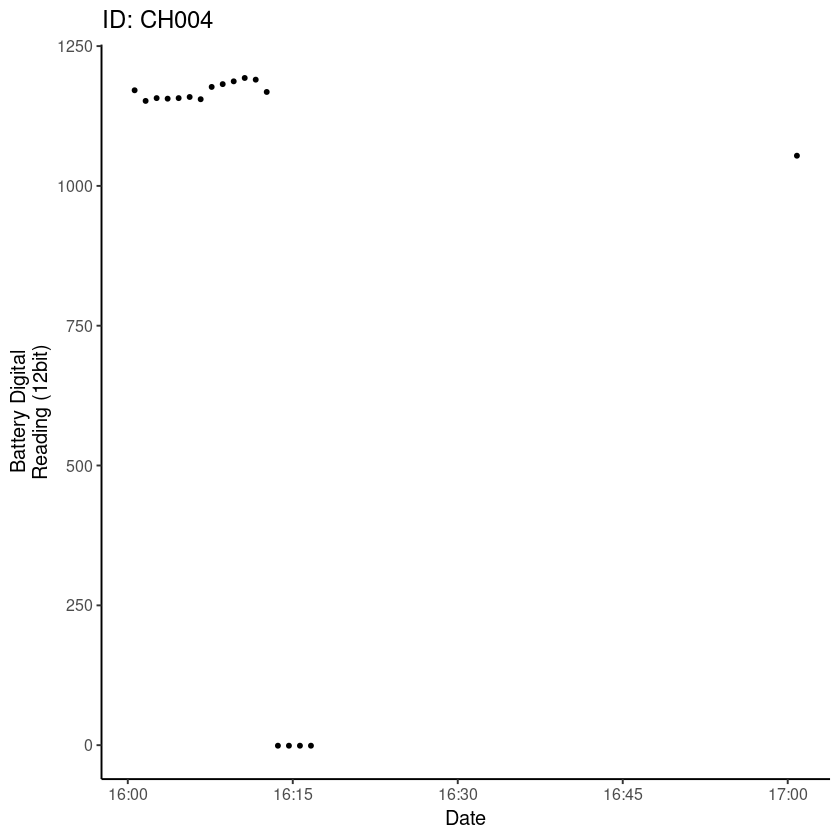

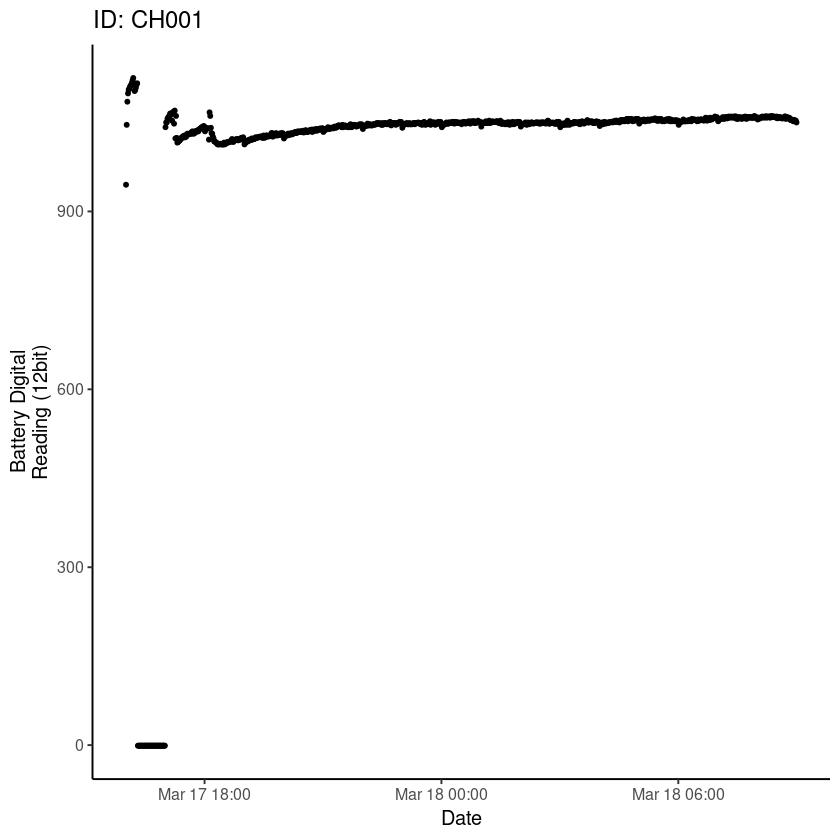

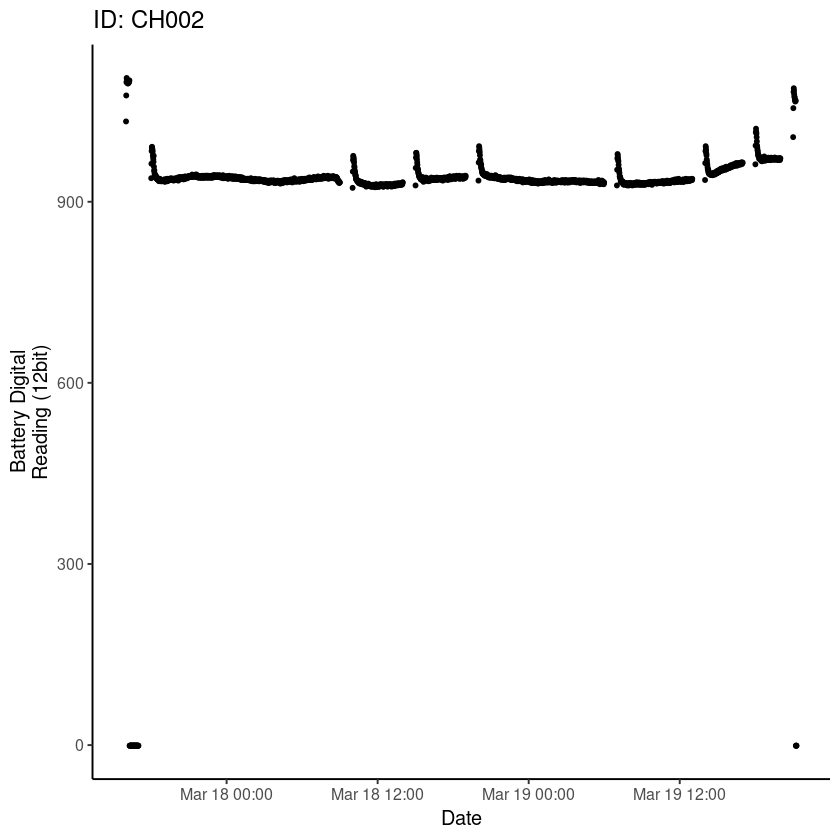

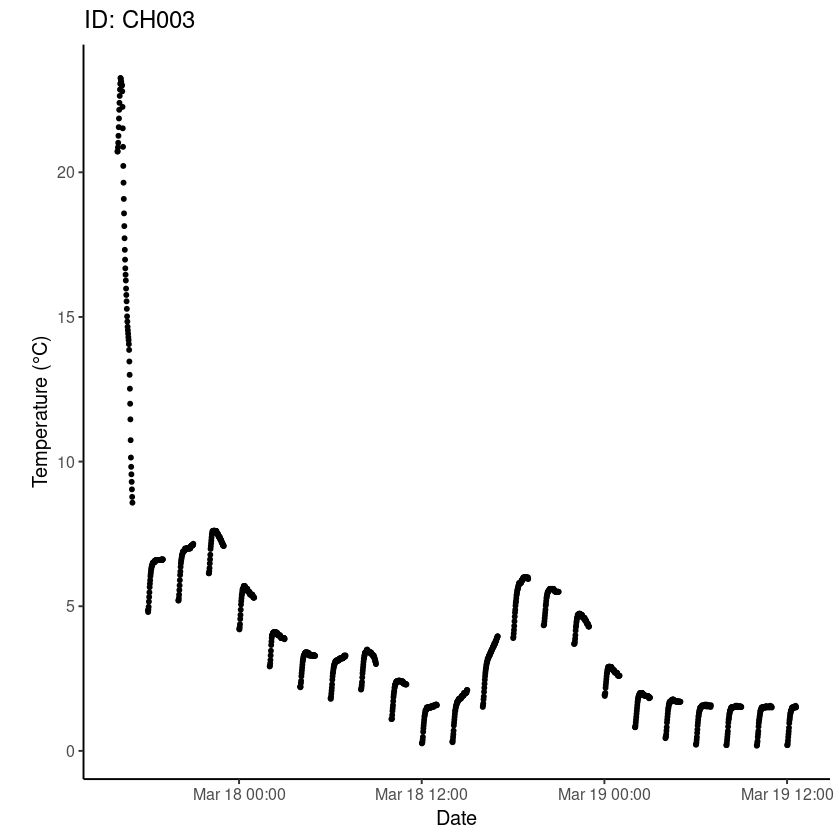

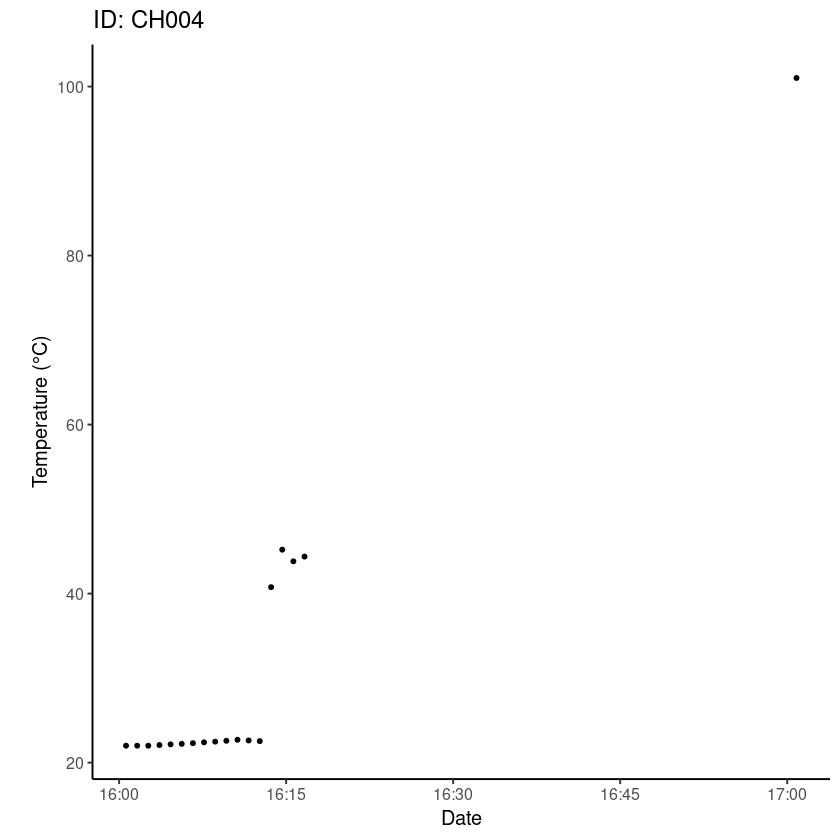

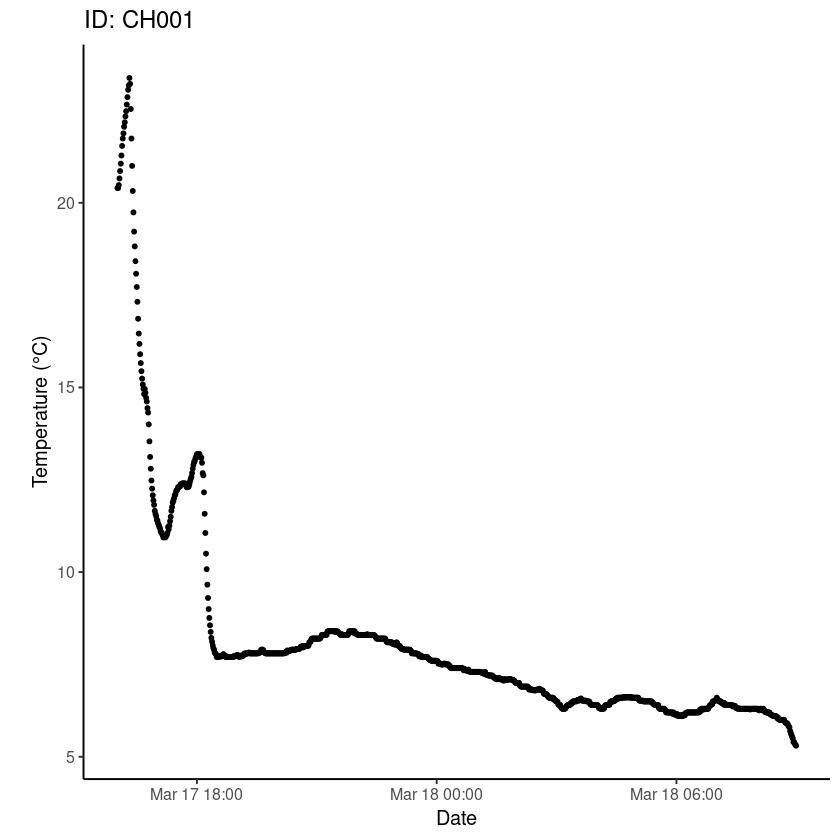

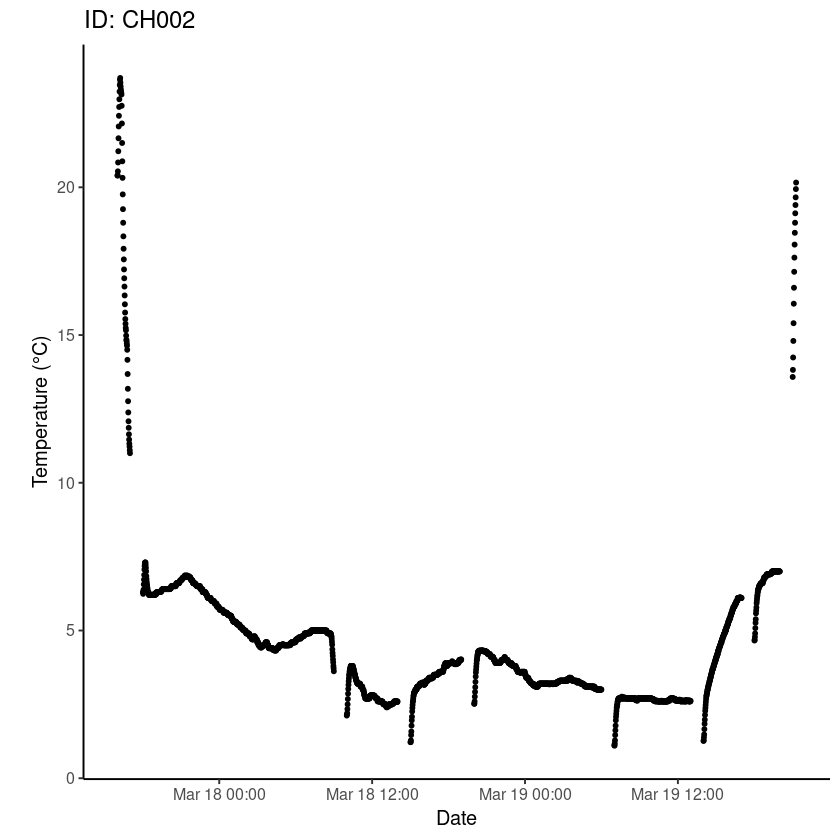

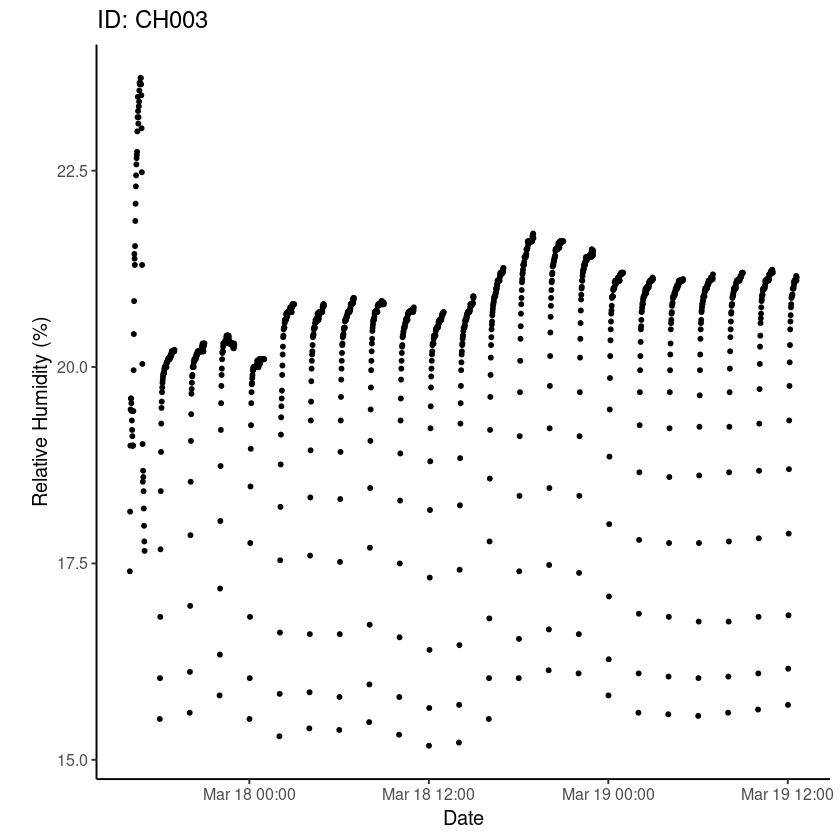

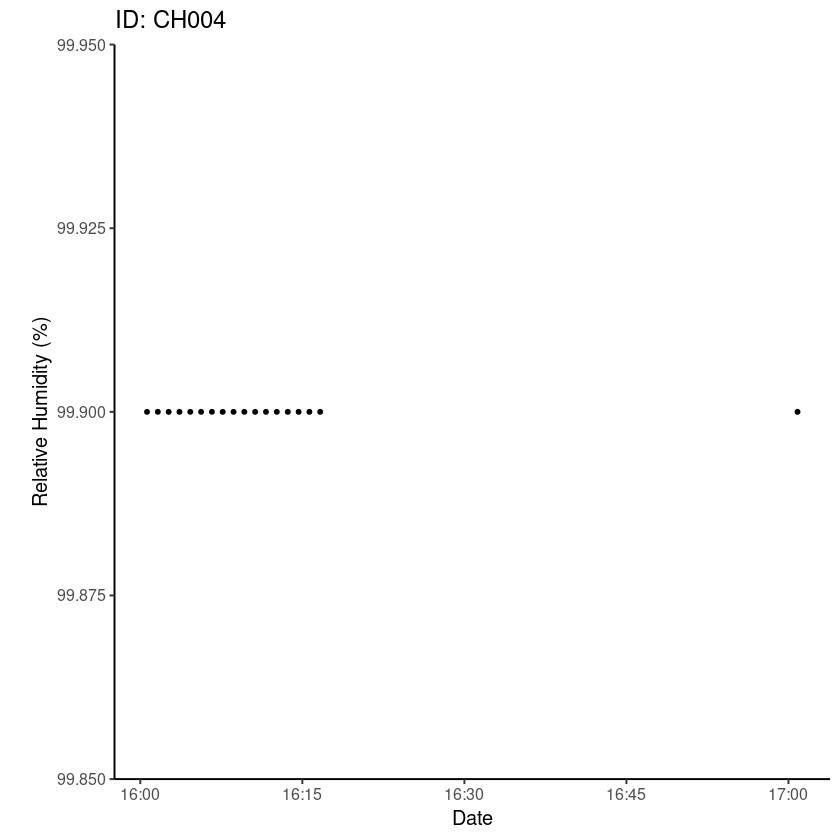

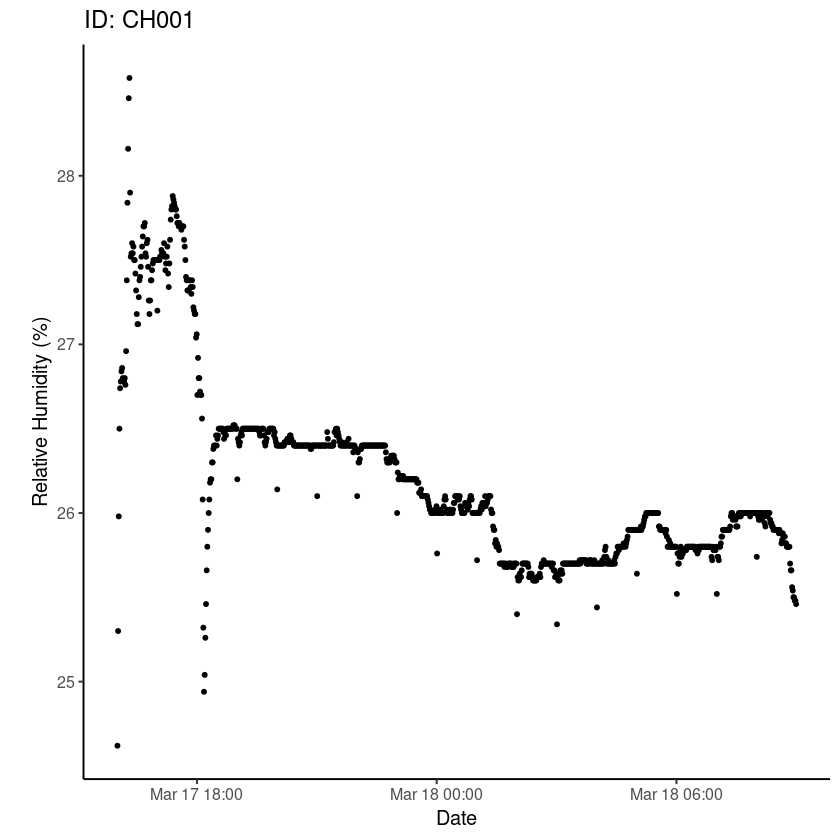

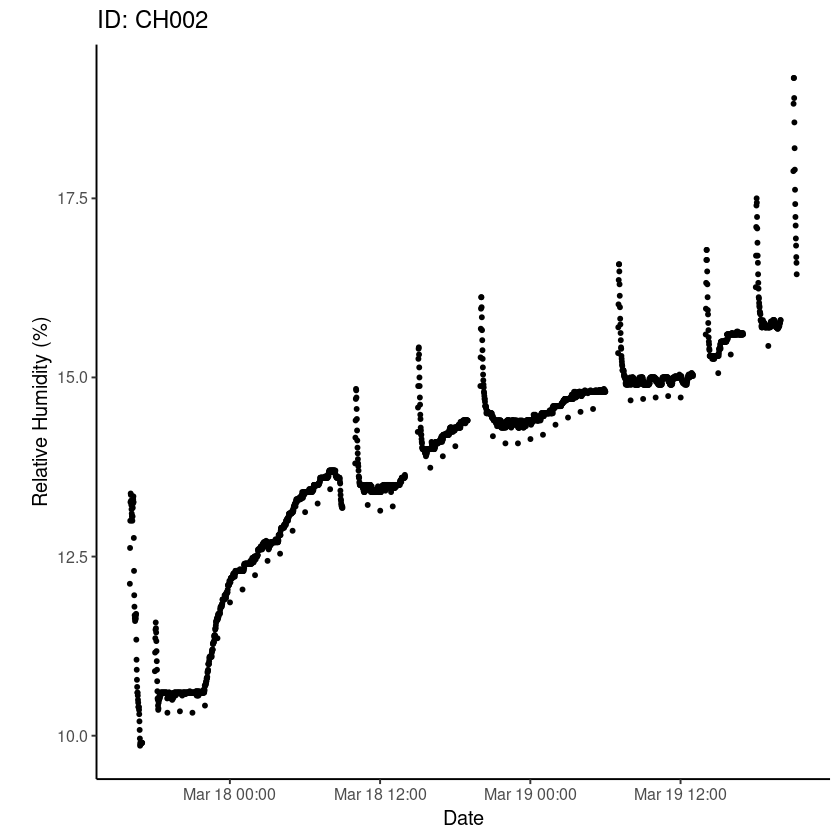

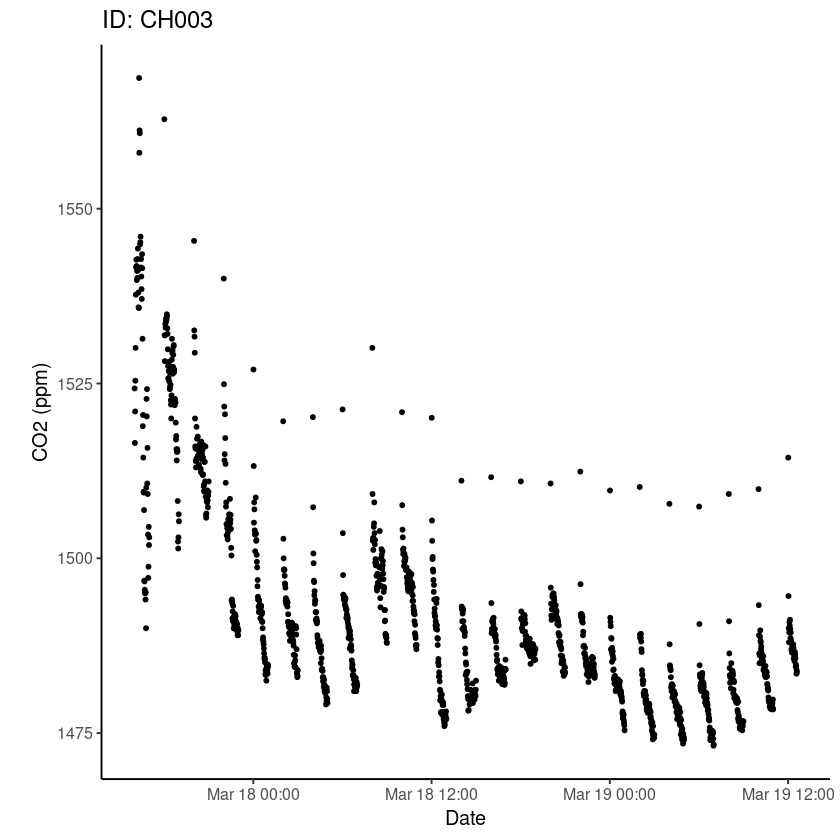

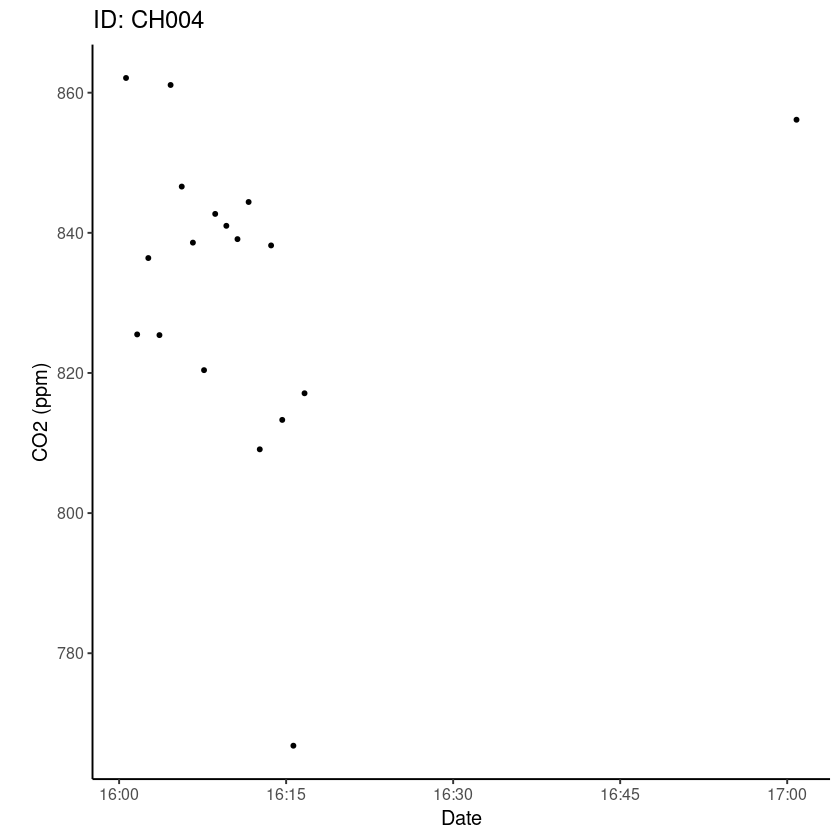

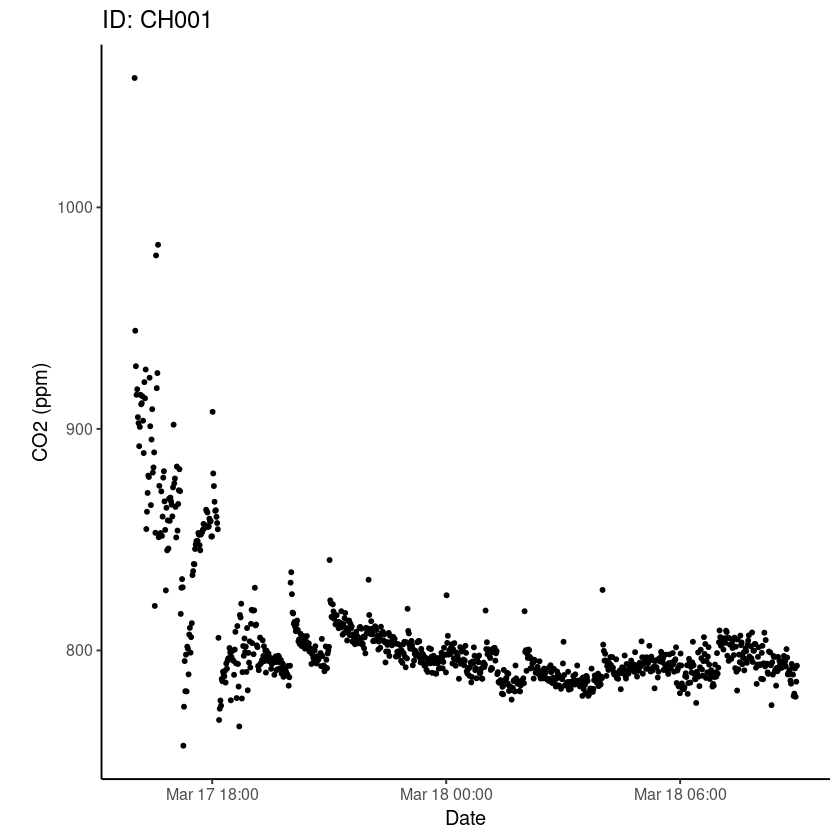

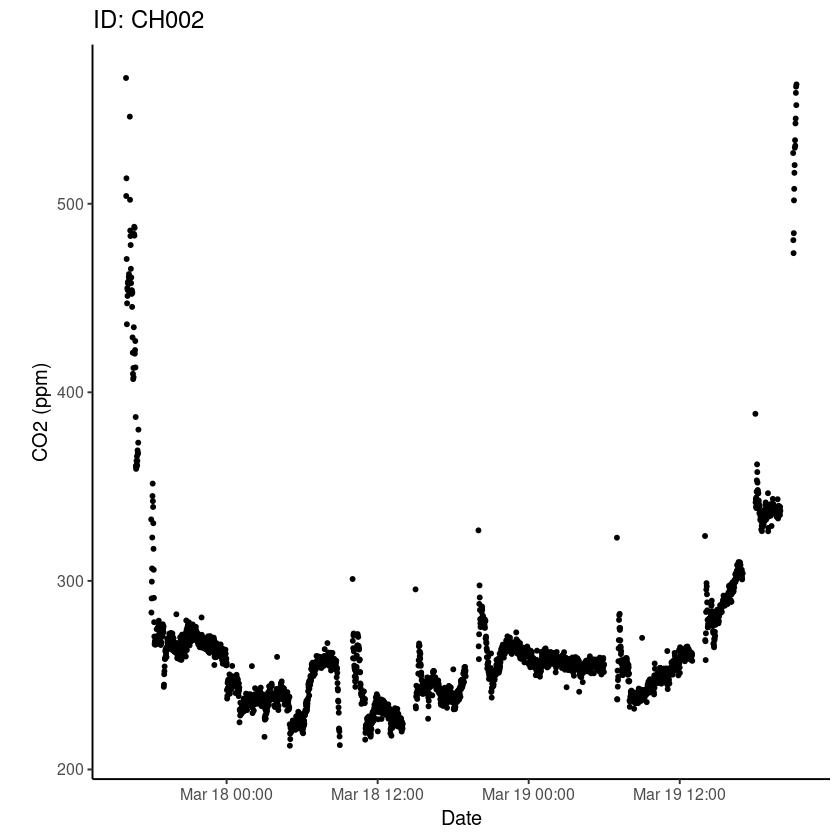

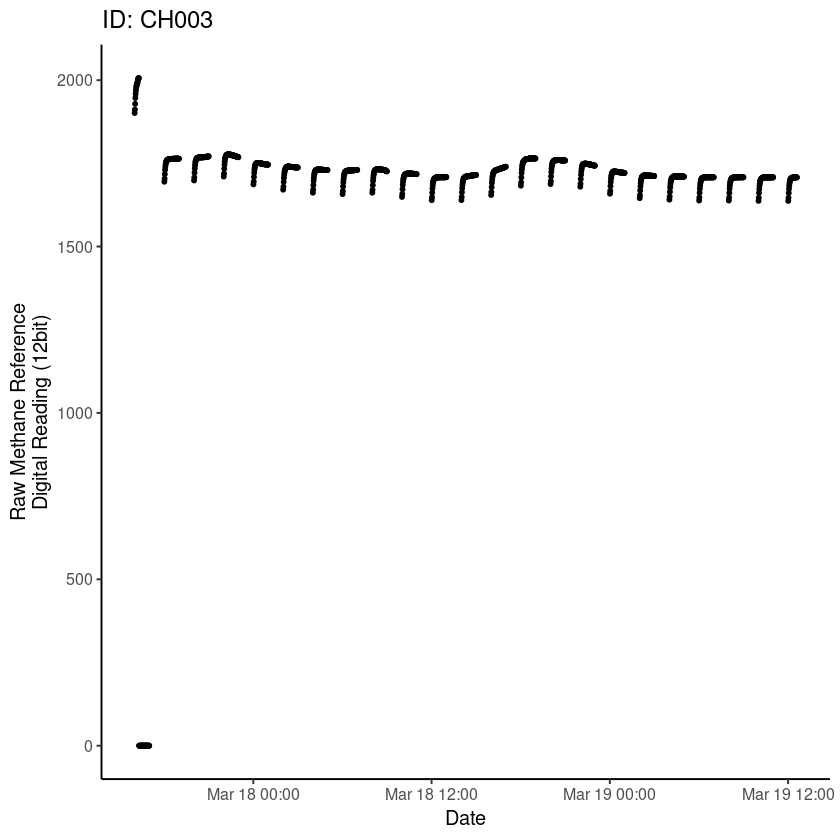

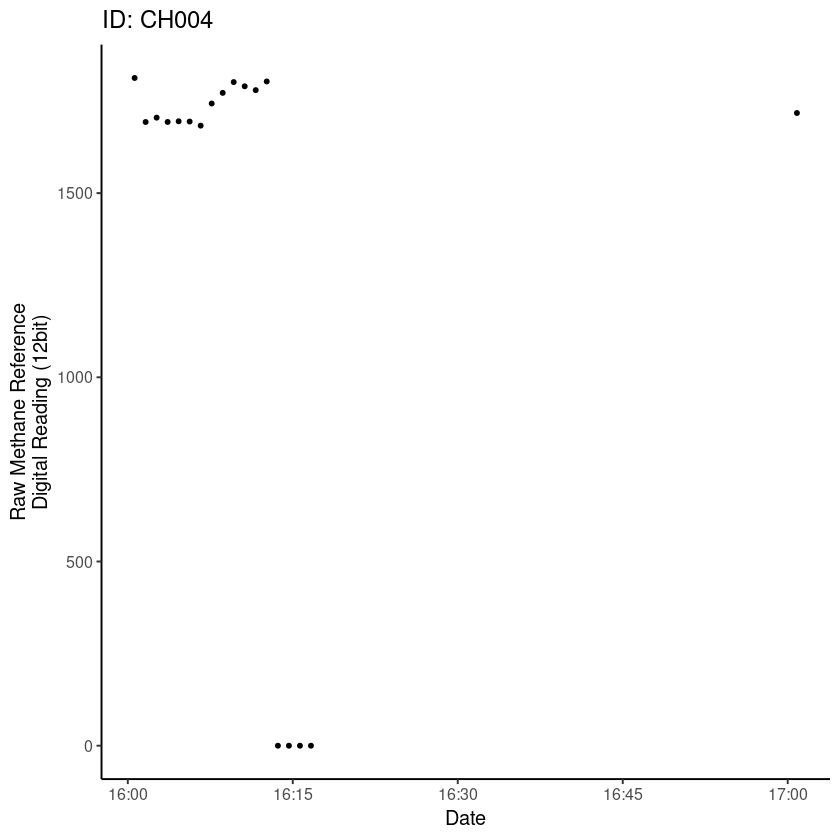

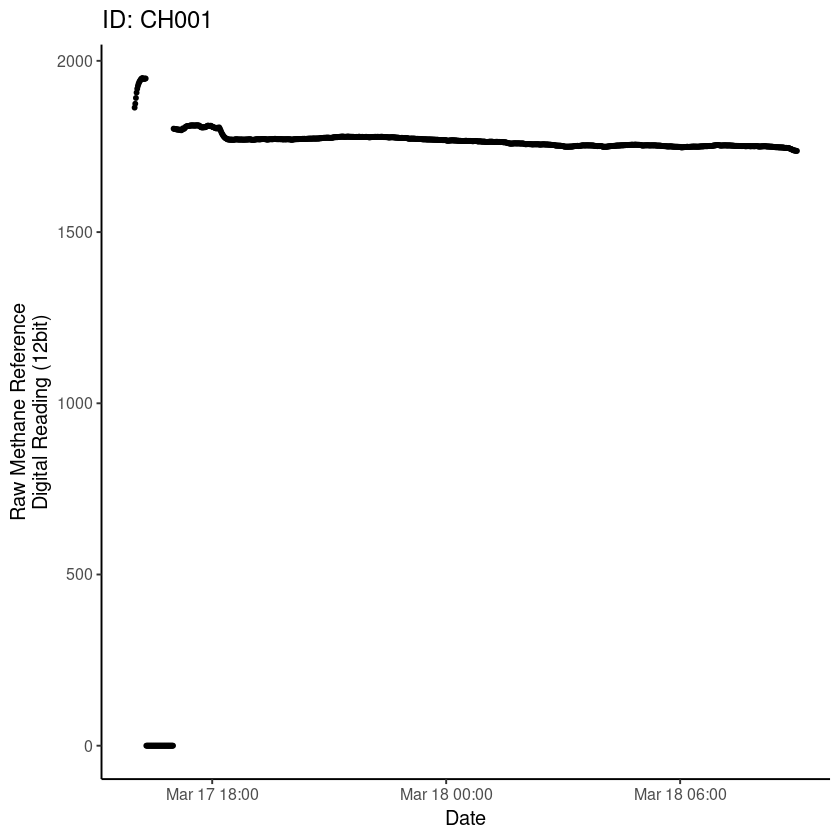

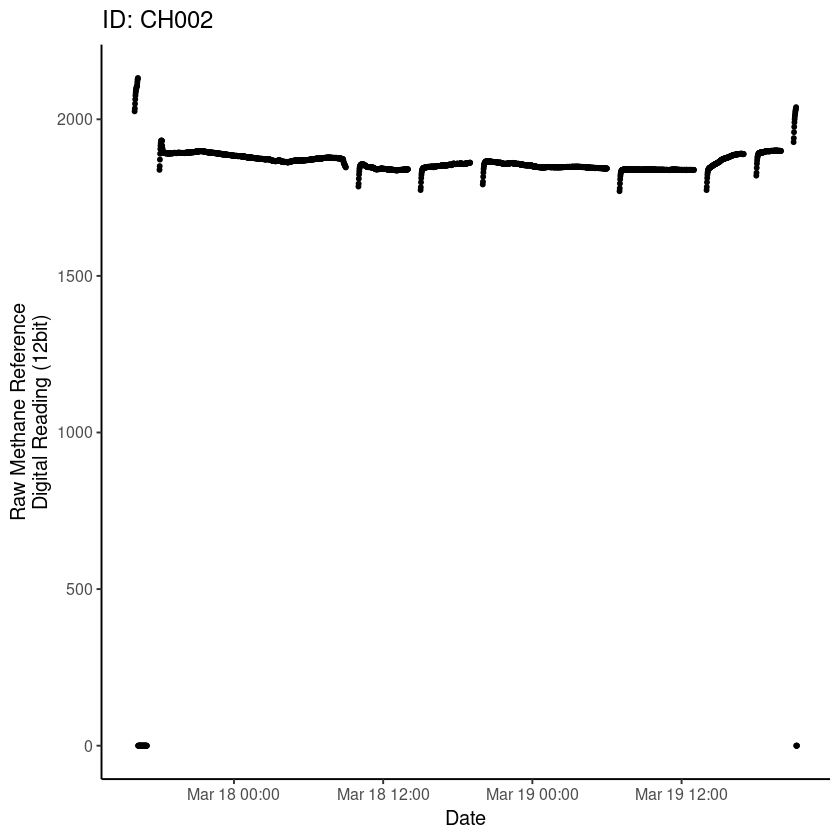

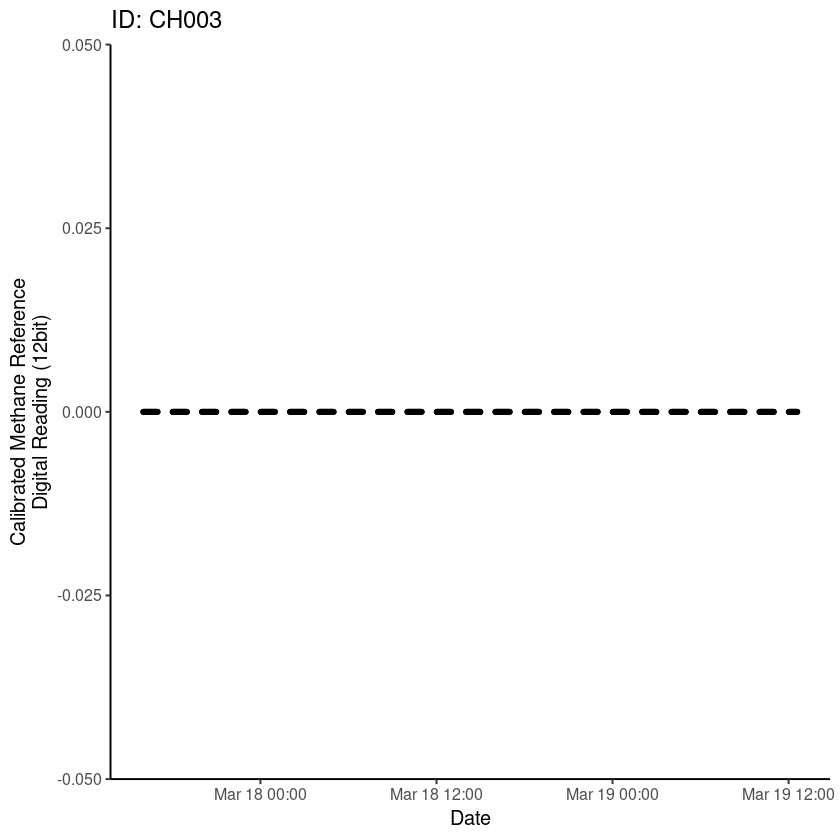

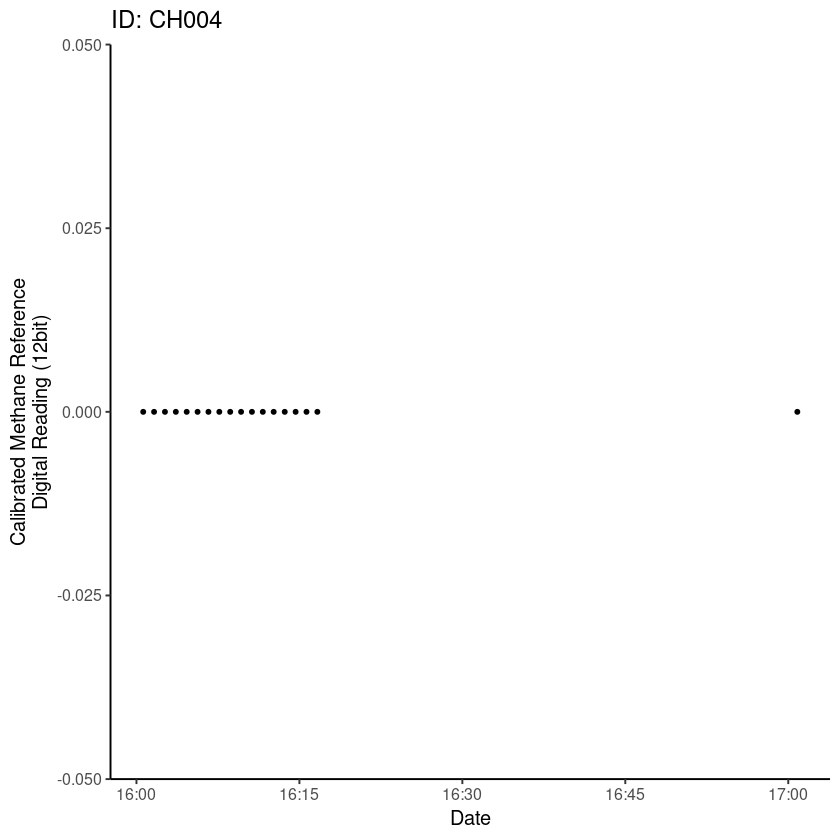

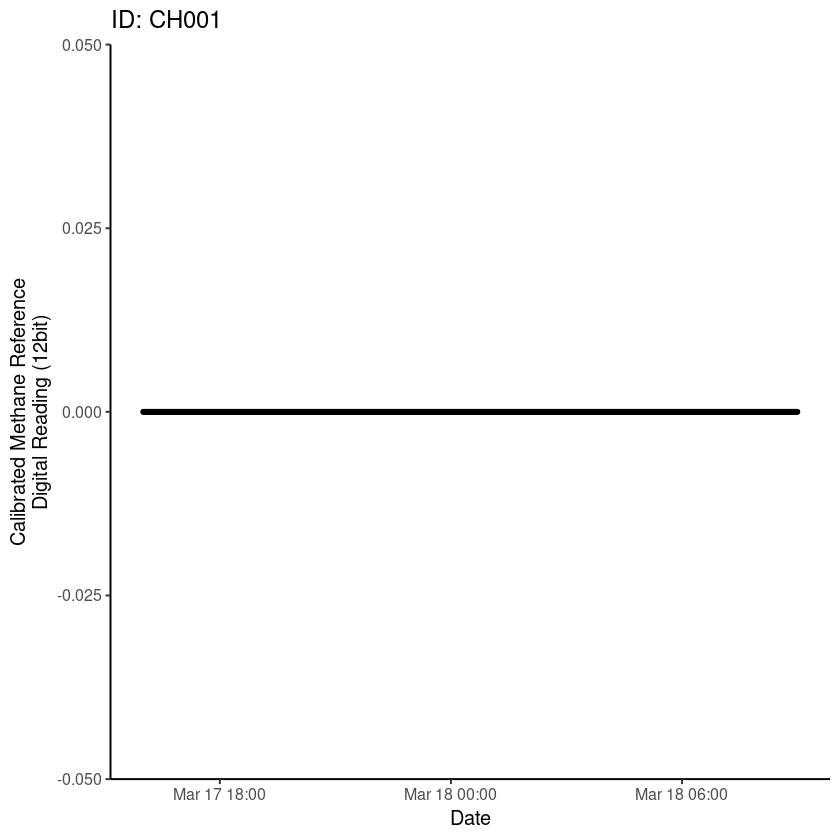

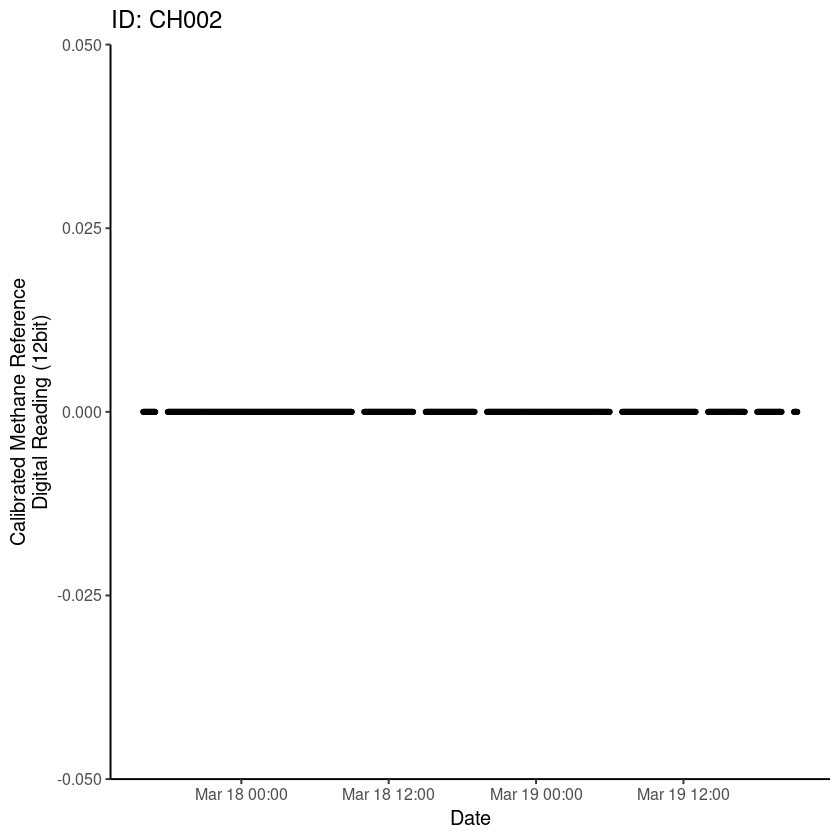

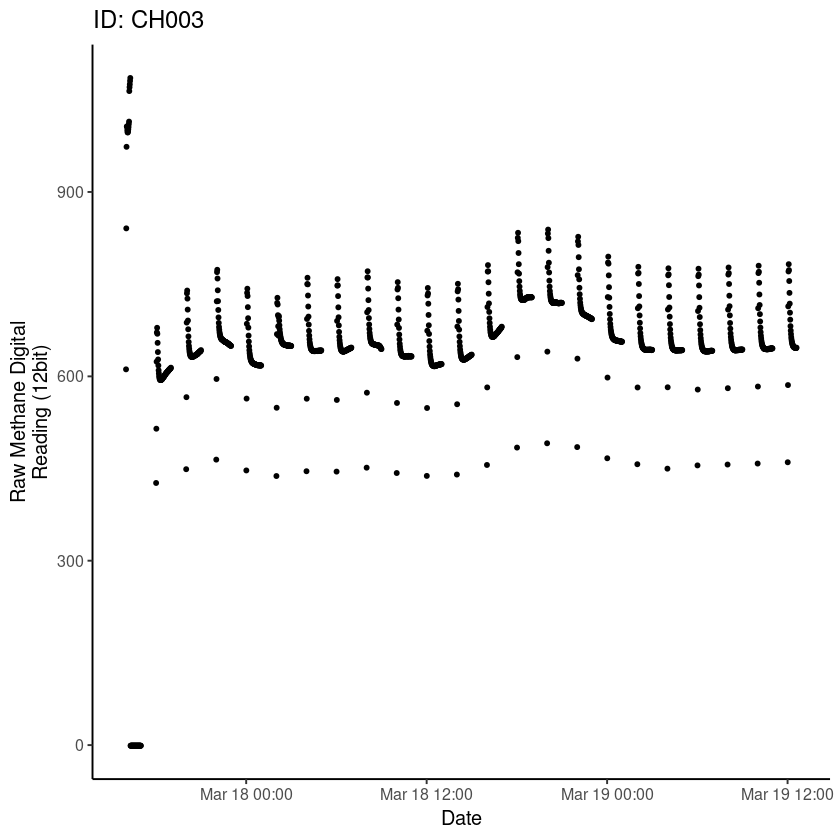

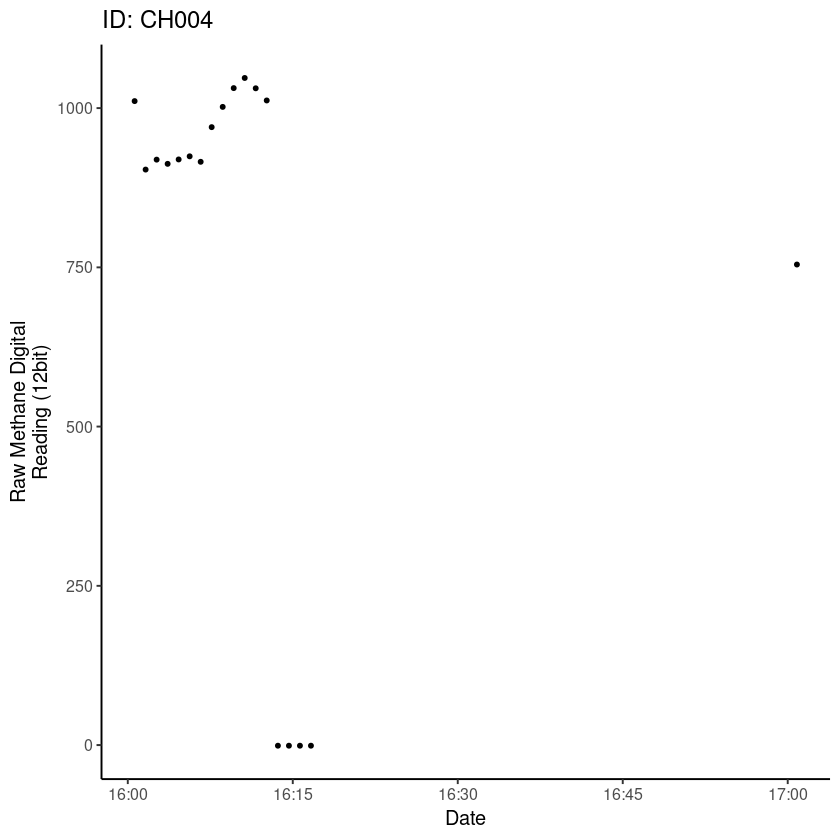

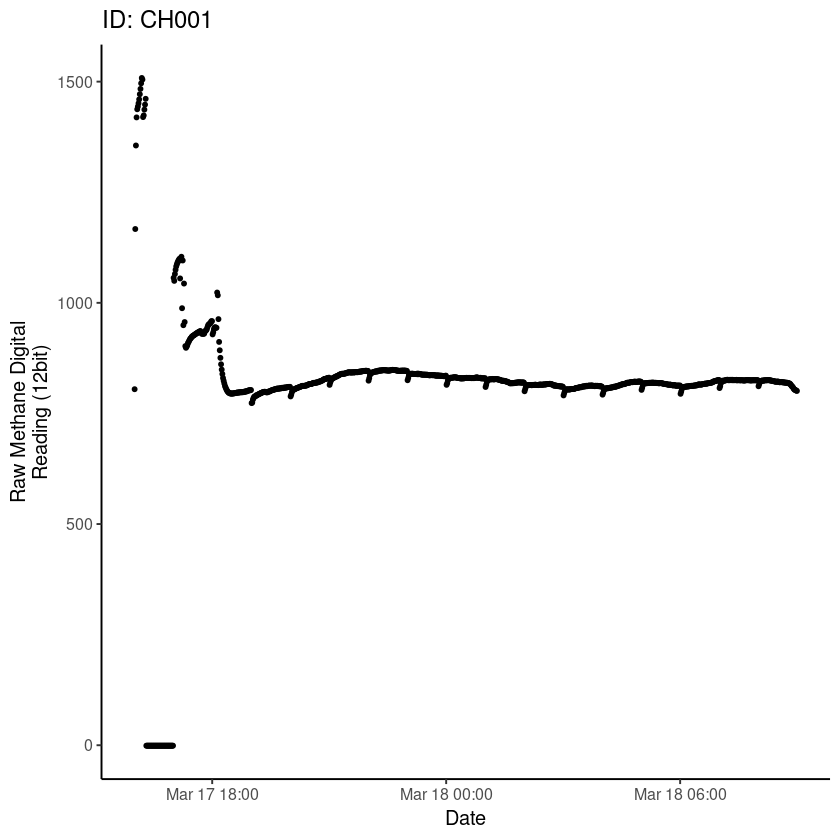

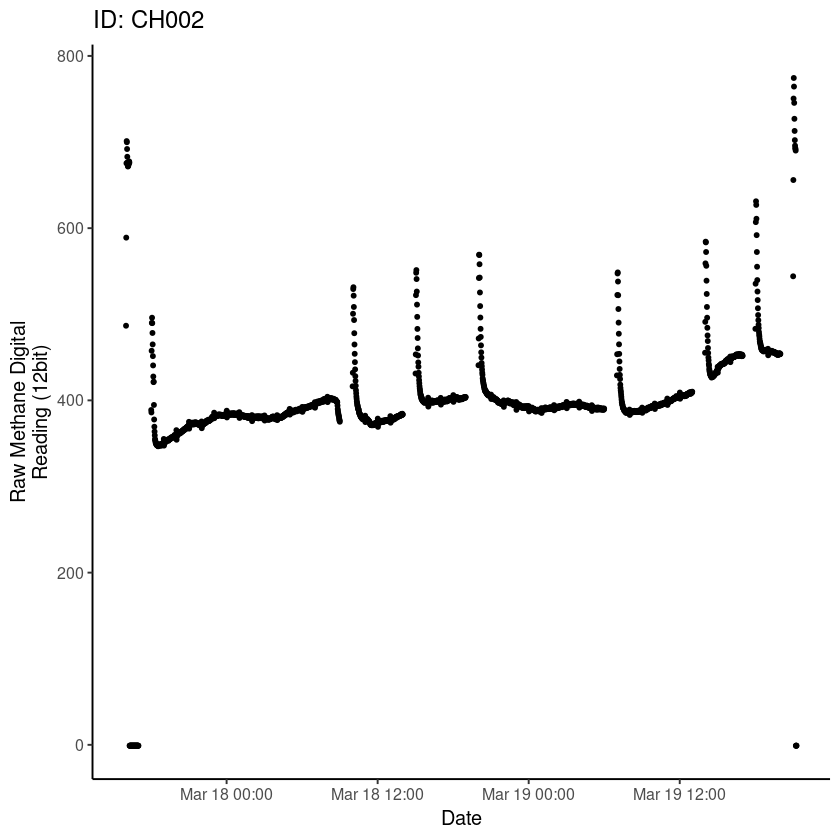

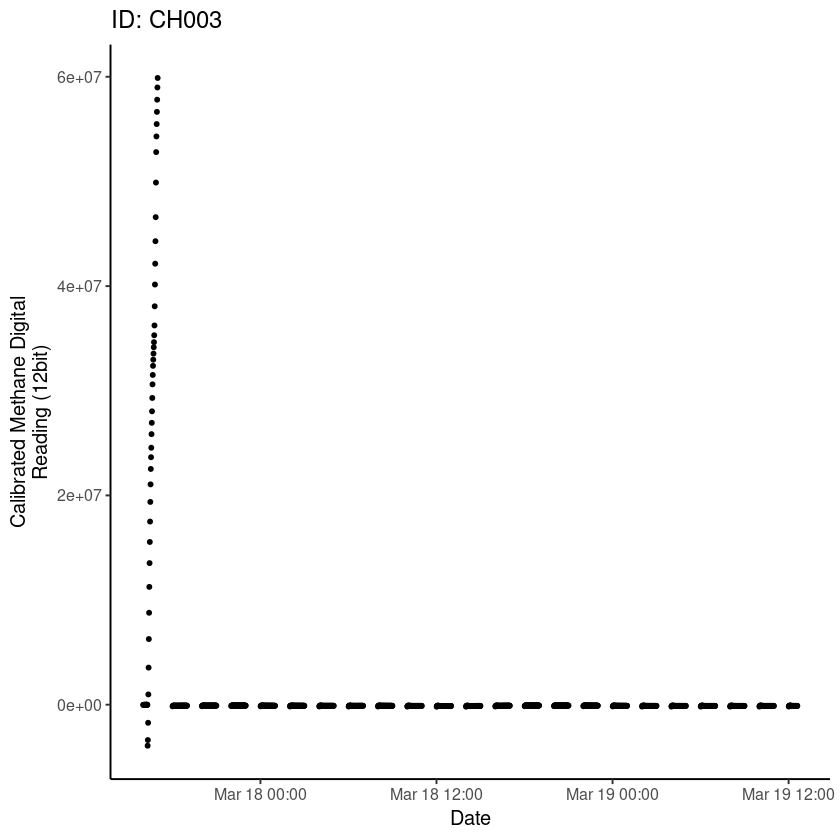

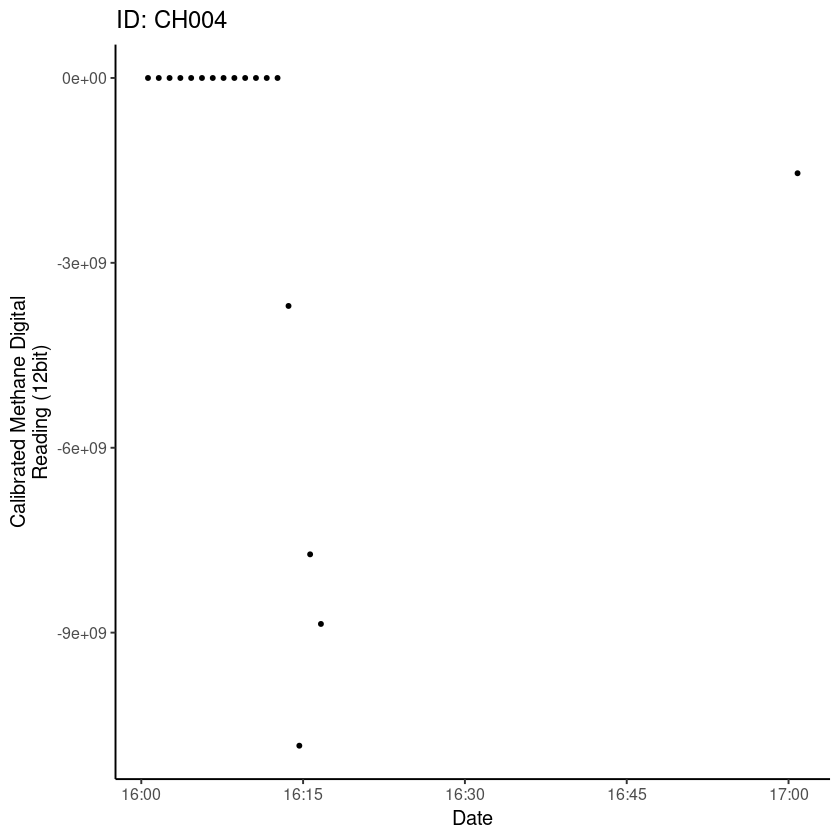

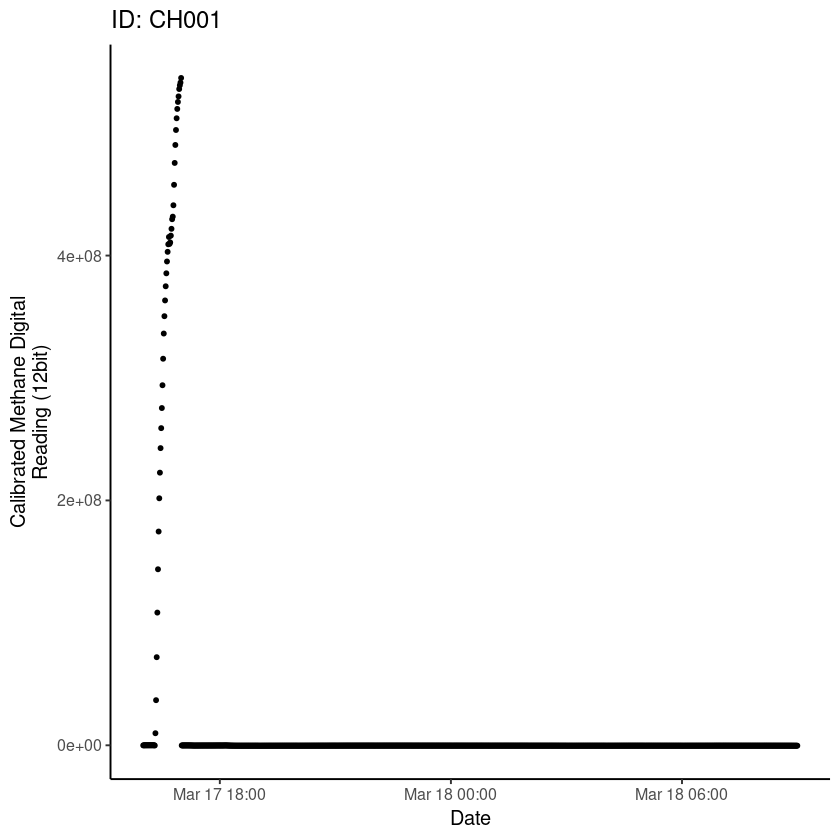

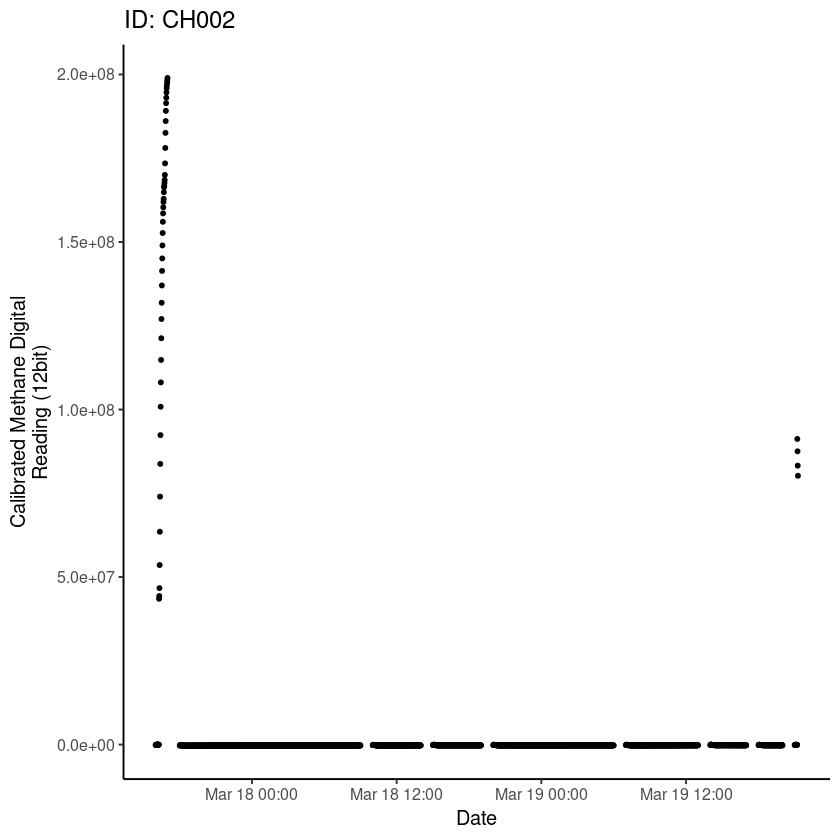

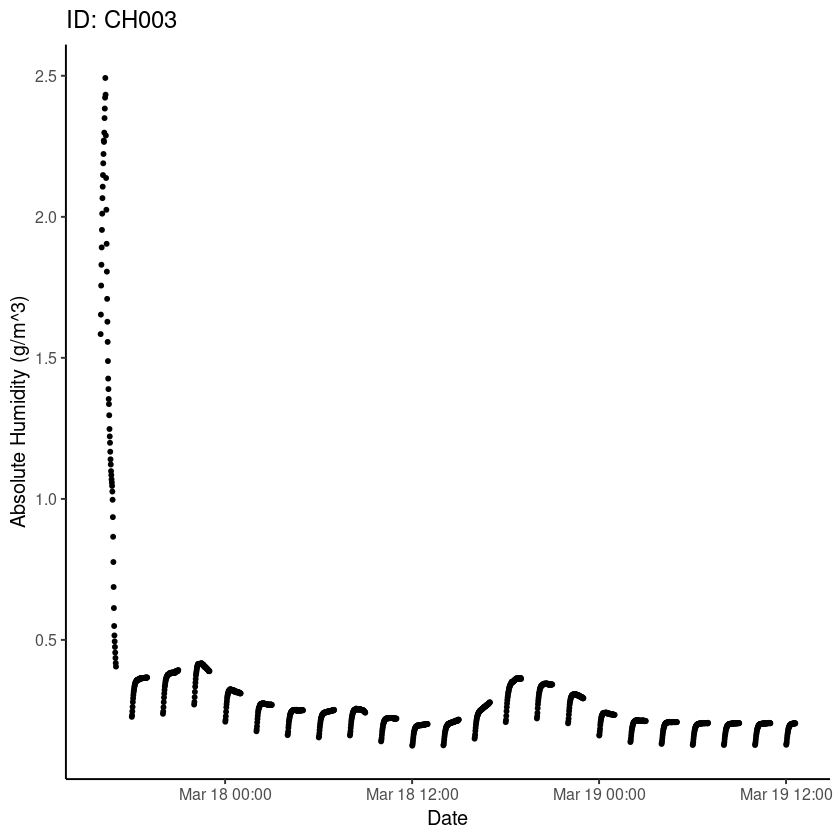

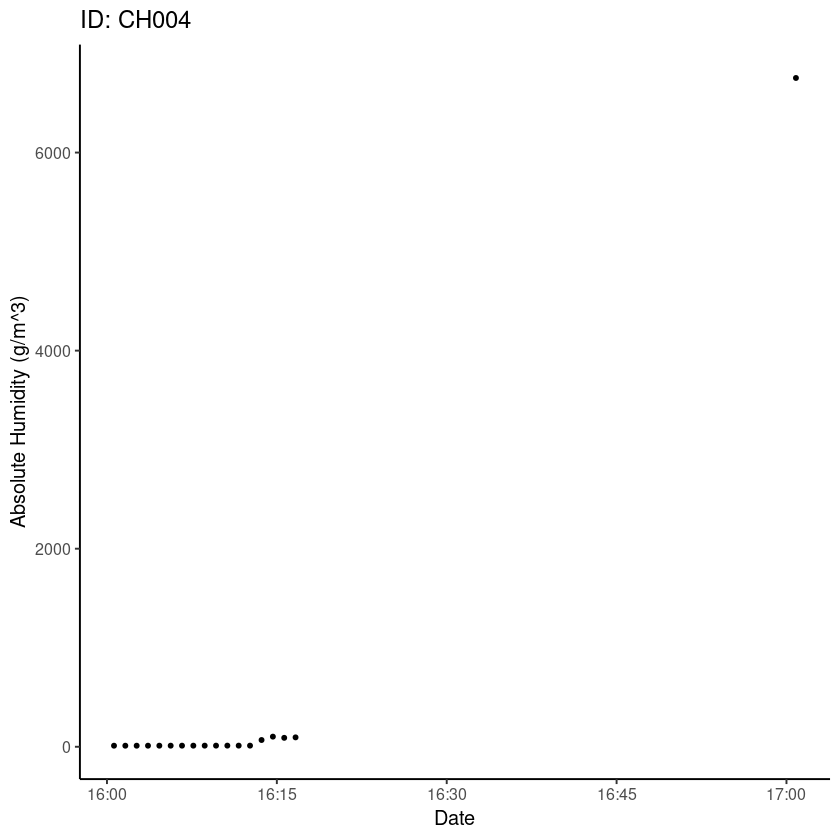

$battery.V
$battery.V$CH003

$battery.V$CH004

$battery.V$CH001

$battery.V$CH002


$dht_C
$dht_C$CH003

$dht_C$CH004

$dht_C$CH001

$dht_C$CH002


$dht_RH
$dht_RH$CH003

$dht_RH$CH004

$dht_RH$CH001

$dht_RH$CH002


$atlas_CO2_ppm
$atlas_CO2_ppm$CH003

$atlas_CO2_ppm$CH004

$atlas_CO2_ppm$CH001

$atlas_CO2_ppm$CH002


$ch4rf_raw
$ch4rf_raw$CH003

$ch4rf_raw$CH004

$ch4rf_raw$CH001

$ch4rf_raw$CH002


$ch4rf_cal
$ch4rf_cal$CH003

$ch4rf_cal$CH004

$ch4rf_cal$CH001

$ch4rf_cal$CH002


$ch4_raw
$ch4_raw$CH003

$ch4_raw$CH004

$ch4_raw$CH001

$ch4_raw$CH002


$ch4_cal
$ch4_cal$CH003

$ch4_cal$CH004

$ch4_cal$CH001

$ch4_cal$CH002


$aH_gm3
$aH_gm3$CH003

$aH_gm3$CH004

$aH_gm3$CH001

$aH_gm3$CH002



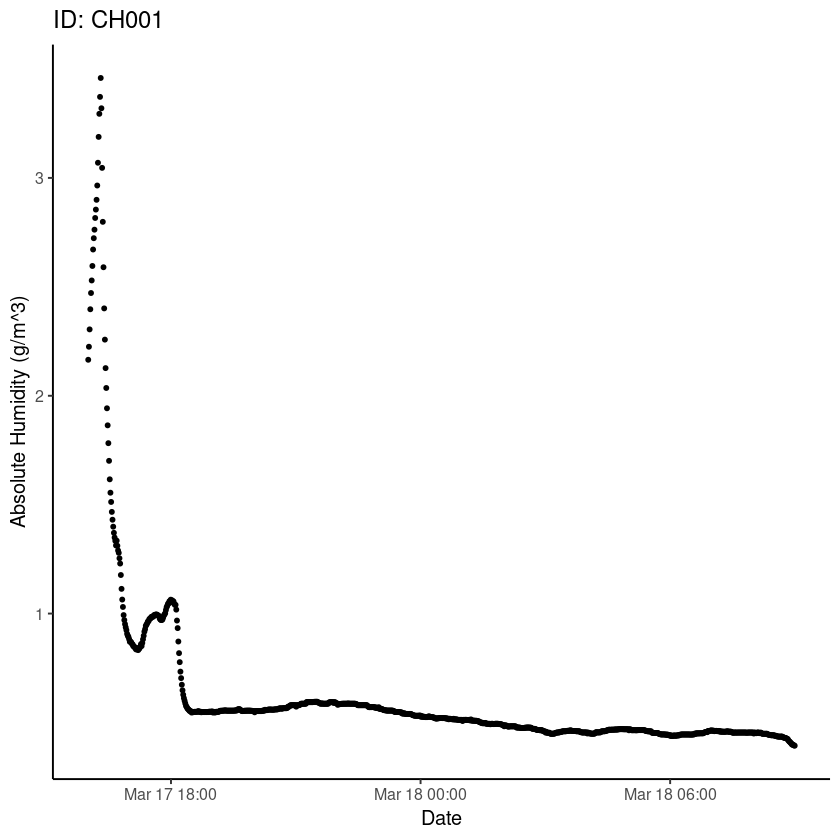

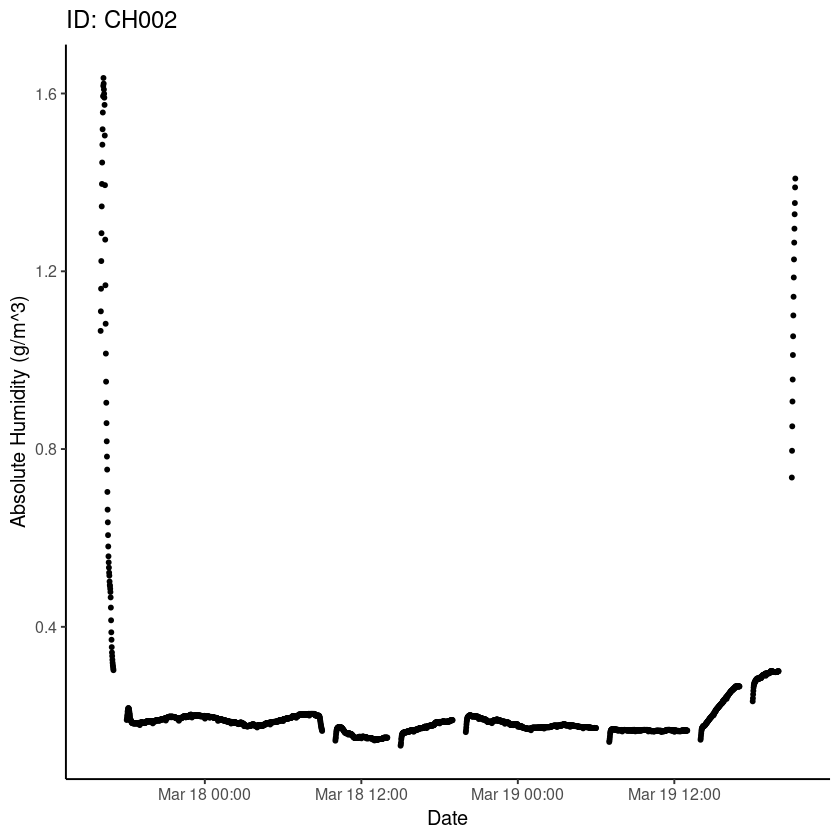

In [16]:
iDvT<-plot_individual_logger_data_v_time(df=summary_rd, idCol="Sensor")
iDvT

savePlotListList(iDvT, tag = "iDvT")

# Calibrated GC data for field deployment 2023-03-17

In [17]:
sampleLogGCDataFile<-"~/Desktop/data/Methane Calibration/field_test/20230317_deployment/GC/GC Calibration Sample Log - Field_samples.csv"
GCsamples<-read.csv(sampleLogGCDataFile)
str(GCsamples)

'data.frame':	18 obs. of  9 variables:
 $ Sample.ID     : chr  "A170100" "A170106" "P170125" "P170131" ...
 $ Sensor.UUID   : chr  "50FF6F068678545226521667" "50FF6F068678545226521667" "50FF6C068678545210222467" "50FF6C068678545210222467" ...
 $ Date.Collected: chr  "2023-03-17" "2023-03-17" "2023-03-17" "2023-03-17" ...
 $ Time.Collected: chr  "13:00" "13:06" "13:25" "13:31" ...
 $ gc.ch4.ppm    : num  2.35 2.11 25.24 27.63 146.32 ...
 $ Date.Run      : chr  "2023-03-21" "2023-03-21" "2023-03-21" "2023-03-21" ...
 $ Sensor        : chr  "CH003" "CH003" "CH004" "CH004" ...
 $ Site          : chr  "ACRE outlet" "ACRE outlet" "LPS" "LPS" ...
 $ Note          : chr  "" "" "" "" ...


In [19]:
# head(GCsamples)
GCsamples$datetime<-paste(GCsamples$Date.Collected,GCsamples$Time.Collected)
GCsamples$datetime<-lubridate::as_datetime(GCsamples$datetime, format="%Y-%m-%d %H:%M", tz="EDT")
GCsamples$Sensor.UUID<-as.factor(GCsamples$Sensor.UUID)
GCsamples$Sensor<-as.factor(GCsamples$Sensor)
GCsamples$Site<-as.factor(GCsamples$Site)
head(GCsamples)

,Sample.ID,Sensor.UUID,Date.Collected,Time.Collected,gc.ch4.ppm,Date.Run,Sensor,Site,Note,datetime
,<chr>,<fct>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>,<chr>,<dttm>
1,A170100,50FF6F068678545226521667,2023-03-17,13:00,2.354967,2023-03-21,CH003,ACRE outlet,,2023-03-17 13:00:00
2,A170106,50FF6F068678545226521667,2023-03-17,13:06,2.108902,2023-03-21,CH003,ACRE outlet,,2023-03-17 13:06:00
3,P170125,50FF6C068678545210222467,2023-03-17,13:25,25.235562,2023-03-21,CH004,LPS,,2023-03-17 13:25:00
4,P170131,50FF6C068678545210222467,2023-03-17,13:31,27.628209,2023-03-21,CH004,LPS,,2023-03-17 13:31:00
5,WD170200,57FF70068387575129270167,2023-03-17,14:00,146.316309,2023-03-21,CH001,PWA dock right,,2023-03-17 14:00:00
6,WD170205t,57FF70068387575129270167,2023-03-17,14:05,75.528149,2023-03-21,CH001,PWA dock right,transferred,2023-03-17 14:05:00


# Align data from GC samples with readings from RRIV

[1] "CH003" "CH004" "CH001" "CH002"

[1] "CH003"
[1] "CH004"


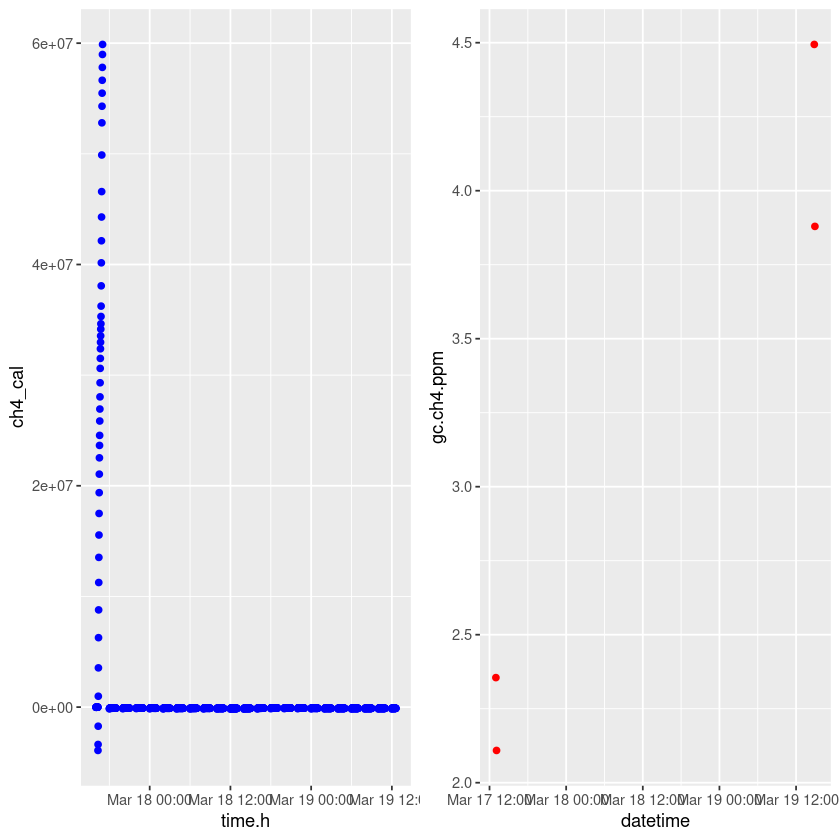

[1] "CH001"


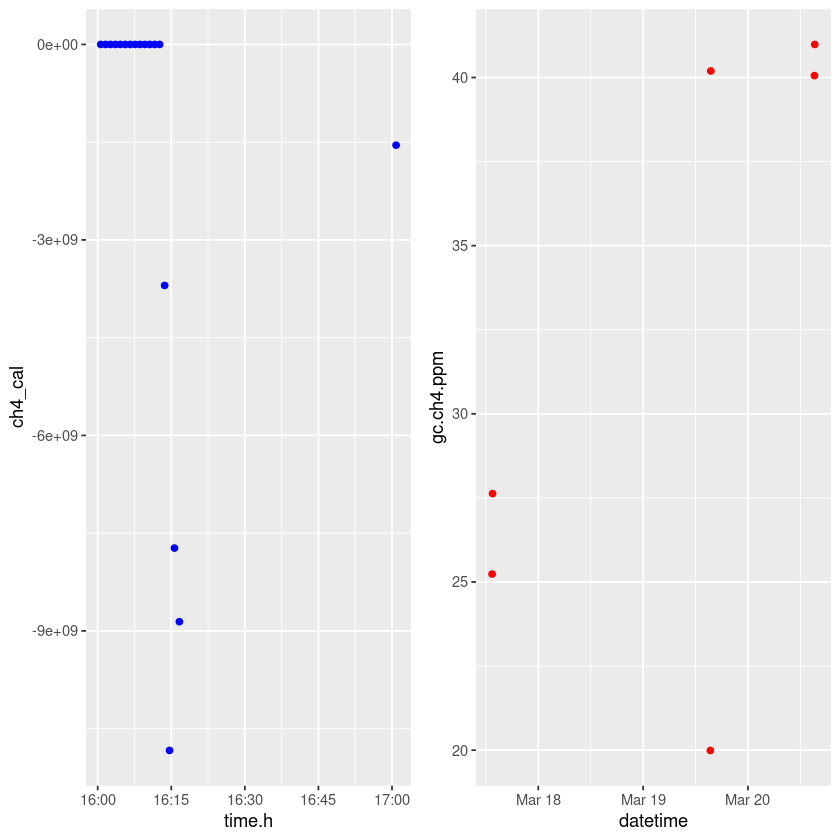

[1] "CH002"


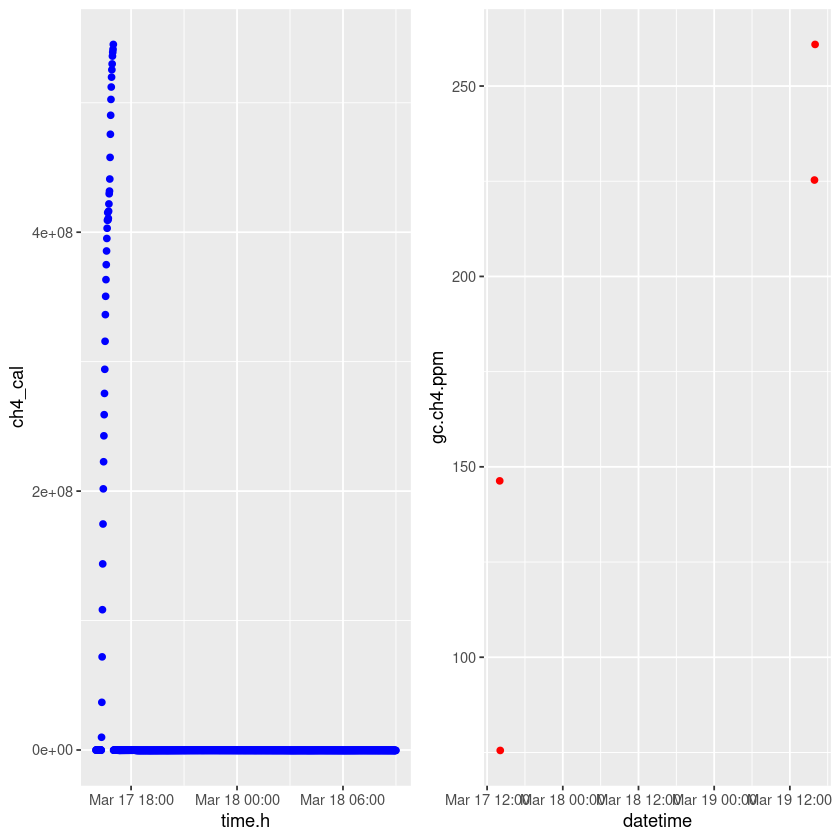

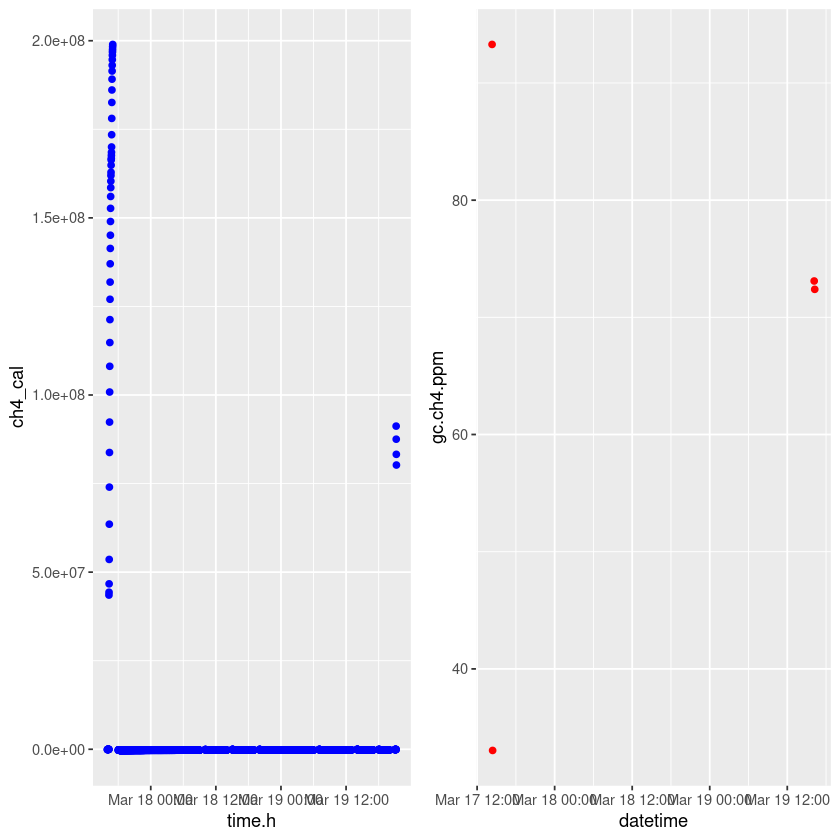

In [49]:
sensors<-unique(summary_rd$Sensor)
sensors
for(sensor in sensors){
    print(sensor)
    a<-ggplot()+geom_point(data=summary_rd[summary_rd$Sensor==sensor,],aes(x=time.h,y=ch4_cal),color="blue")
    b<-ggplot()+geom_point(data=GCsamples[GCsamples$Sensor==sensor,], aes(x=datetime, y=gc.ch4.ppm), color="red")
    print(ggarrange(a,b))
}


function (x, y, ...) 
UseMethod("plot")
<bytecode: 0x562662afb020>
<environment: namespace:base>
